https://machinelearningmastery.com/multi-class-imbalanced-classification/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
seed = 0
np.random.seed(seed)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from sklearn.model_selection import train_test_split

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import lightgbm as lgb

## configs

In [3]:
th_prop = 0.005
th_n_dis = 10 # minimum number of samples for diseases
list_proj_test = ['E-MTAB-10026', 'ours', 'GSE135779', 'GSE138266']

version = '230815_LGBM_SMOTE'

In [4]:
import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

## Load dataset

In [5]:
df = pd.read_csv('../output/metaanalysis/230122_CD4T_queryL2_output.csv', index_col=0)
df['disease'] = df['disease'].replace('COVID-19', 'Covid')
df.head()

disease  disease_duration condition   age race     sex  \
sample                                                                  
GSE157278:HC-1      HC               NaN        HC  1.32  NaN  female   
GSE157278:HC-2      HC               NaN        HC  1.32  NaN  female   
GSE157278:HC-3      HC               NaN        HC  1.32  NaN  female   
GSE157278:HC-4      HC               NaN        HC  1.32  NaN  female   
GSE157278:HC-5      HC               NaN        HC  1.32  NaN  female   

               immunosuppressant immunosuppressant_duration    project  \
sample                                                                   
GSE157278:HC-1               NaN                        NaN  GSE157278   
GSE157278:HC-2               NaN                        NaN  GSE157278   
GSE157278:HC-3               NaN                        NaN  GSE157278   
GSE157278:HC-4               NaN                        NaN  GSE157278   
GSE157278:HC-5               NaN                        NaN  GSE157278   

                TcmPHLDA3  ...  TemTph  TemraTh1  Tnaive  TnaiveAct  \
sample                     ...                                        
GSE157278:HC-1          1  ...      13        23     733        141   
GSE157278:HC-2          1  ...      20        21     724        247   
GSE157278:HC-3          3  ...      25        32     919        133   
GSE157278:HC-4          0  ...      23        65    1735        276   
GSE157278:HC-5          0  ...       4        17     540         98   

                TnaiveMX1  TnaiveSOX4  TregAct  TregEff  TregNaive  n_total  
sample                                                                       
GSE157278:HC-1         39         169       23       13         37     1673  
GSE157278:HC-2         41         112       22       28         27     1618  
GSE157278:HC-3          9         158       20       15         25     1875  
GSE157278:HC-4         10         155       22       30         64     2933  
GSE157278:HC-5          5          83       13       20         22     1128  

[5 rows x 28 columns]

In [6]:
list_celltype = ['TcmPHLDA3', 'TcmTfh', 'TcmTh0', 'TcmTh0Act', 'TcmTh17', 'TcmTh2',
       'TemTh1', 'TemTh117', 'TemTh1pre', 'TemTph', 'TemraTh1', 'Tnaive',
       'TnaiveAct', 'TnaiveMX1', 'TnaiveSOX4', 'TregAct', 'TregEff',
       'TregNaive']

# select celltype with freq > X%
ser_prop = df[~df.project.isin(list_proj_test)].sum()[list_celltype] / df[~df.project.isin(list_proj_test)].sum()['n_total']
list_celltype_select = list(ser_prop[ser_prop >=th_prop].index)
list_celltype_select

/tmp/ipykernel_2091147/915041242.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ser_prop = df[~df.project.isin(list_proj_test)].sum()[list_celltype] / df[~df.project.isin(list_proj_test)].sum()['n_total']


['TcmTfh',
 'TcmTh0',
 'TcmTh17',
 'TcmTh2',
 'TemTh1',
 'TemTh117',
 'TemTh1pre',
 'TemTph',
 'TemraTh1',
 'Tnaive',
 'TnaiveAct',
 'TnaiveMX1',
 'TnaiveSOX4',
 'TregAct',
 'TregEff',
 'TregNaive']

In [7]:
df_NMF = pd.read_csv('../output/metaanalysis/230122_CD4T_queryL2_output_withNMF.csv')
# scaling
df_NMF[['NMF_{}'.format(i) for i in range(12)]] = MinMaxScaler().fit_transform(df_NMF[['NMF_{}'.format(i) for i in range(12)]])
df_NMF_tidy = df_NMF.melt(id_vars=['sample', 'clusterL2'], value_vars=['NMF_{}'.format(i) for i in range(12)])
df_NMF_piv = df_NMF_tidy.pivot_table(values='value', columns=['clusterL2', 'variable'], index='sample')
df_NMF_piv = df_NMF_piv[list_celltype_select]
df_NMF_piv.columns = [x[0]+':'+x[1] for x in df_NMF_piv.columns]

df = pd.merge(df, df_NMF_piv, left_index=True, right_index=True)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (2,4,22,24,26,27,28,30,31,33,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
list_nmf_col_use = list(df_NMF_piv.loc[:,df_NMF_piv.columns.str.split(':').str.get(0).isin(['Tnaive', 'TcmTh0'])].columns)


In [9]:
for i,c in enumerate(list_celltype_select):
    df['freq_{}'.format(c)] = df[c] / df['n_total']
df['sexmale'] = (df['sex'] == 'male') * 1

In [10]:
df.disease.unique()

array(['HC', 'pSS', 'SLE', 'Sarcoidosis', 'Covid', 'Kawasaki', 'CD',
       'Psoriasis', 'Celiac', 'Neurosarcoidosis', 'MS', 'Tuberculosis',
       'MG', 'ParkinsonDisease', 'RA', 'Flu', 'PPP', 'AD', 'T1D', 'BD',
       'UC'], dtype=object)

In [11]:
df.disease.value_counts()

HC                  306
Covid               205
SLE                 199
Psoriasis            62
MS                   52
Sarcoidosis          27
RA                   20
Celiac               11
T1D                  11
ParkinsonDisease      8
PPP                   7
UC                    7
Kawasaki              6
Neurosarcoidosis      5
pSS                   5
Flu                   5
CD                    4
BD                    4
Tuberculosis          3
MG                    3
AD                    3
Name: disease, dtype: int64

In [12]:
df.disease.value_counts().max()

306

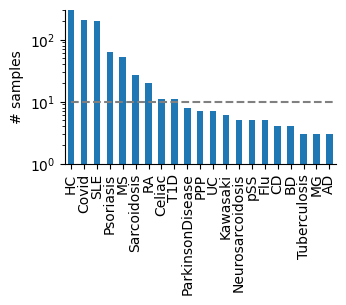

In [13]:
plt.figure(figsize=(3.5,2))
df.disease.value_counts().plot.bar()
sns.despine()
plt.ylabel('# samples')
plt.yscale('log')
plt.ylim(10**0,df.disease.value_counts().max())
plt.hlines(10,0,21, linestyles='--', color='grey')
plt.savefig('../scanpy/{}'.format(version) + '/bar_numsamples.pdf', bbox_inches='tight')

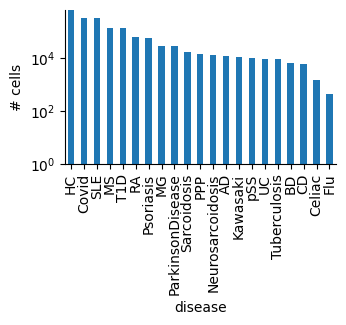

In [14]:
plt.figure(figsize=(3.5,2))
df.groupby(by='disease').sum()['n_total'].sort_values(ascending=False).plot.bar()
sns.despine()
plt.ylabel('# cells')
plt.yscale('log')
plt.ylim(10**0,df.groupby(by='disease').sum()['n_total'].max())
plt.savefig('../scanpy/{}'.format(version) + '/bar_cells.pdf', bbox_inches='tight')

## Binary classification

In [15]:
dict_result = {}
dict_result_nmf = {}
dict_result_onlynmf = {}
dict_fi = {}

In [16]:
#instantiate the model
model = LogisticRegression()

# model = lgb.LGBMClassifier()

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier()

# from sklearn.svm import SVC
# model = SVC()

## SLE

In [17]:
disease = 'SLE'

In [18]:
df[df.disease=='HC'].project.value_counts()

GSE174188            97
GSE144744            31
GSE194315            29
E-MTAB-10026         21
CeD                  17
GSE158055            16
GSE135779            14
1M_PBMC_T1D_Parse    10
GSE125527             8
GSE132338             8
GSE150728             6
3993994               6
GSE138266             5
GSE157278             5
HRA000155             4
GSE149689             4
GSE185857             4
GSE198616             4
ours                  3
GSE133028             3
GSE168732             3
PRJNA605083           2
577860                2
GSE163314             2
GSE181279             2
Name: project, dtype: int64

In [19]:
df[df['disease'] == 'SLE'].project.value_counts()

GSE174188    156
GSE135779     40
ours           3
Name: project, dtype: int64

In [20]:
df_train = pd.concat([df[(df.project.isin(['GSE174188', 'ours'])) & (df.disease.isin(['HC', 'SLE']))],
                      df[(df.project=='GSE144744')&(df.disease=='HC')],
                      df[(df.project=='GSE194315')&(df.disease=='HC')].iloc[:-1]])
df_test = pd.concat([df[df.project.isin(['GSE135779'])],
                     df[(df.project=='E-MTAB-10026')&(df.disease=='HC')],
                     df[(df.project=='GSE138266')&(df.disease=='HC')]
                    ])

In [21]:
# check sample duplications
assert df_train.index.duplicated().sum() == 0
assert df_test.index.duplicated().sum() == 0
assert len(set(df_train.index) & set(df_test.index)) == 0

In [22]:
df_train.disease.value_counts()

SLE    159
HC     159
Name: disease, dtype: int64

In [23]:
df_test.disease.value_counts()

HC     40
SLE    40
Name: disease, dtype: int64

In [24]:
df_train['y'] = (df_train.disease == disease) * 1
df_test['y'] = (df_test.disease == disease) * 1

X_train = df_train[['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
X_train = np.array(X_train)
y_train = np.array(df_train.loc[:, 'y'])

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_test = df_test[['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
y_test = np.array(df_test.loc[:, 'y'])

X_test = scaler.transform(X_test)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [25]:
model.fit(X_train,y_train)

LogisticRegression()

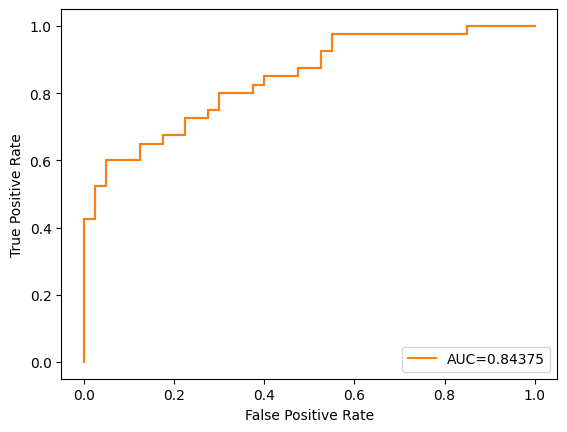

In [26]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [27]:
dict_result[disease] = [fpr, tpr, auc]

<AxesSubplot: ylabel='Feature'>

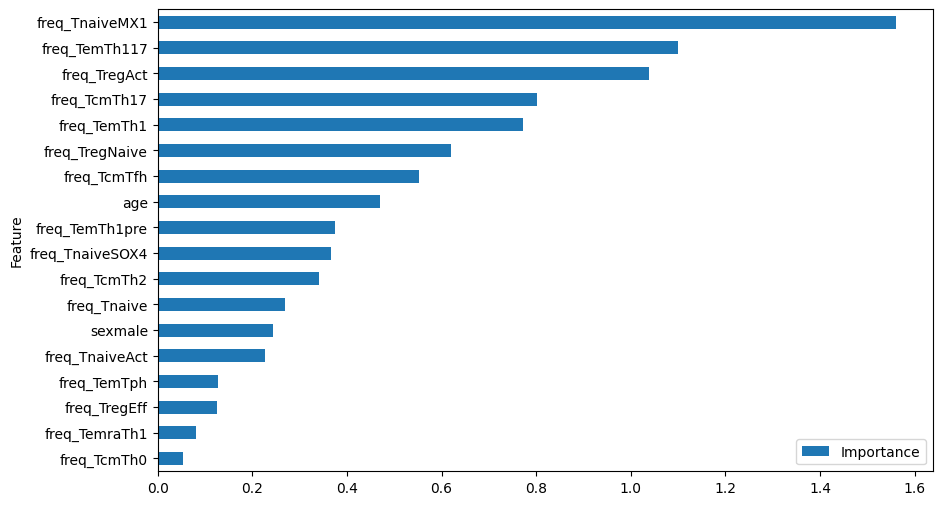

In [28]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': ['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale'], 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [29]:
X_train = df_train[['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
# y = np.array(df.loc[rows_sel, 'y'])
y_train = np.array(df_train['y'])

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X_train)

X_train = imp.transform(X_train)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_test = df_test[['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
X_test = np.array(X_test)
X_test = imp.transform(X_test)
X_test = scaler.transform(X_test)
y_test = np.array(df_test['y'])

model.fit(X_train,y_train)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


LogisticRegression()

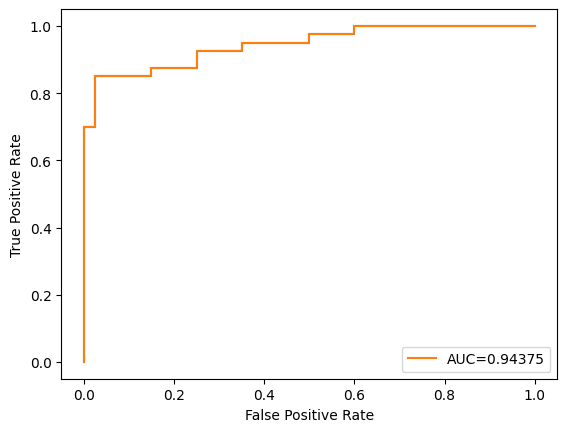

In [30]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [31]:
dict_result_nmf[disease] = [fpr, tpr, auc]

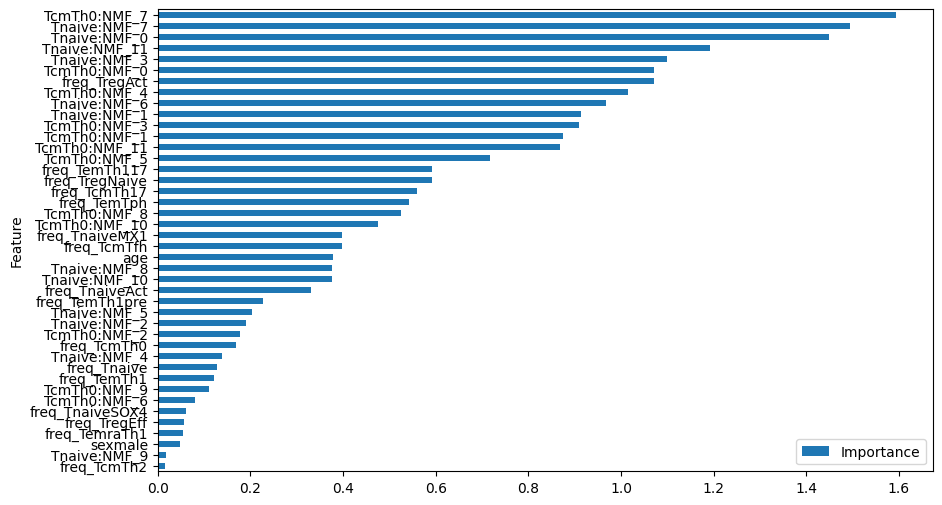

In [32]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': ['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale'], 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
dict_fi[disease] = feature_importance

In [33]:
X_train = df_train[list_nmf_col_use + ['age', 'sexmale']]
# y = np.array(df.loc[rows_sel, 'y'])
y_train = np.array(df_train['y'])

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X_train)

X_train = imp.transform(X_train)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_test = df_test[list_nmf_col_use + ['age', 'sexmale']]
X_test = np.array(X_test)
X_test = imp.transform(X_test)
X_test = scaler.transform(X_test)
y_test = np.array(df_test['y'])

model.fit(X_train,y_train)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


LogisticRegression()

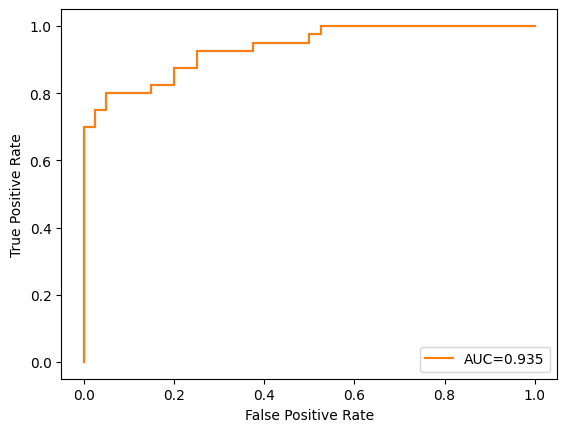

In [34]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [35]:
dict_result_onlynmf[disease] = [fpr, tpr, auc]

<AxesSubplot: ylabel='Feature'>

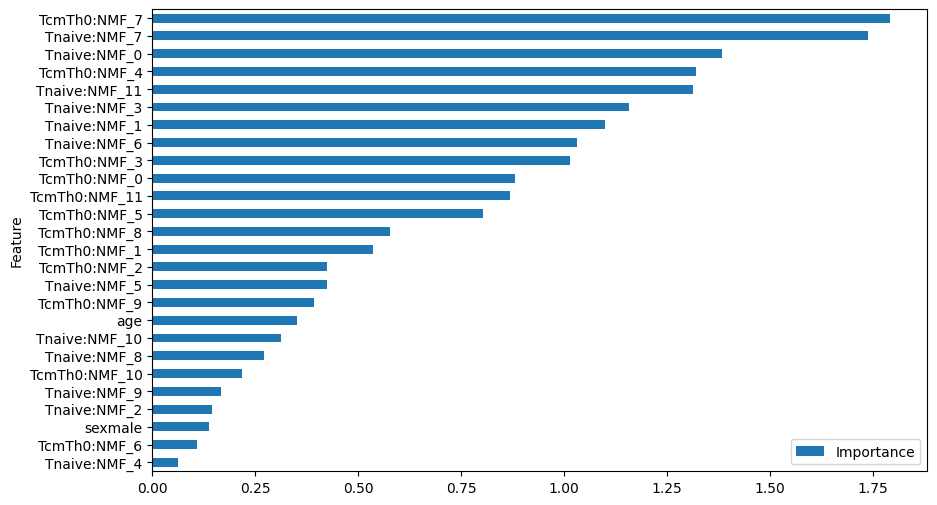

In [36]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': list_nmf_col_use + ['age', 'sexmale'], 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [37]:
feature_importance

Feature  Importance
18   Tnaive:NMF_4    0.063048
8    TcmTh0:NMF_6    0.108263
25        sexmale    0.138029
16   Tnaive:NMF_2    0.144761
23   Tnaive:NMF_9    0.167633
2   TcmTh0:NMF_10    0.217201
22   Tnaive:NMF_8    0.272258
14  Tnaive:NMF_10    0.312070
24            age    0.350845
11   TcmTh0:NMF_9    0.391979
19   Tnaive:NMF_5    0.423594
4    TcmTh0:NMF_2    0.425238
1    TcmTh0:NMF_1    0.535040
10   TcmTh0:NMF_8    0.576169
7    TcmTh0:NMF_5    0.802880
3   TcmTh0:NMF_11    0.868576
0    TcmTh0:NMF_0    0.881765
5    TcmTh0:NMF_3    1.015166
20   Tnaive:NMF_6    1.031198
13   Tnaive:NMF_1    1.099879
17   Tnaive:NMF_3    1.156811
15  Tnaive:NMF_11    1.313721
6    TcmTh0:NMF_4    1.320813
12   Tnaive:NMF_0    1.384149
21   Tnaive:NMF_7    1.738163
9    TcmTh0:NMF_7    1.792048

## Covid

In [38]:
disease = 'Covid'

In [39]:
df[df['disease'] == disease].project.value_counts()

GSE158055       102
E-MTAB-10026     89
GSE149689         8
GSE150728         6
Name: project, dtype: int64

In [40]:
df[df.disease=='HC'].project.value_counts()

GSE174188            97
GSE144744            31
GSE194315            29
E-MTAB-10026         21
CeD                  17
GSE158055            16
GSE135779            14
1M_PBMC_T1D_Parse    10
GSE125527             8
GSE132338             8
GSE150728             6
3993994               6
GSE138266             5
GSE157278             5
HRA000155             4
GSE149689             4
GSE185857             4
GSE198616             4
ours                  3
GSE133028             3
GSE168732             3
PRJNA605083           2
577860                2
GSE163314             2
GSE181279             2
Name: project, dtype: int64

In [41]:
df_train = pd.concat([df[(df.project.isin(['GSE158055', 'GSE149689', 'GSE150728'])) & (df.disease.isin(['HC', disease]))],
                      df[(df.project=='GSE174188')&(df.disease=='HC')].iloc[:-7]])
df_test = pd.concat([df[df.project.isin(['E-MTAB-10026'])],
                    df[(df.project=='GSE194315')&(df.disease=='HC')],
                    df[(df.project=='GSE135779')&(df.disease=='HC')],
                    df[(df.project=='GSE144744')&(df.disease=='HC')].iloc[:-6]
                    ])

In [42]:
# check sample duplications
assert df_train.index.duplicated().sum() == 0
assert df_test.index.duplicated().sum() == 0
assert len(set(df_train.index) & set(df_test.index)) == 0

In [43]:
df_train.disease.value_counts()

Covid    116
HC       116
Name: disease, dtype: int64

In [44]:
df_test.disease.value_counts()

Covid    89
HC       89
Name: disease, dtype: int64

In [45]:
df_train['y'] = (df_train.disease == disease) * 1
df_test['y'] = (df_test.disease == disease) * 1

X_train = df_train[['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
X_train = np.array(X_train)
y_train = np.array(df_train.loc[:, 'y'])

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_test = df_test[['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
y_test = np.array(df_test.loc[:, 'y'])

X_test = scaler.transform(X_test)

model.fit(X_train,y_train)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


LogisticRegression()

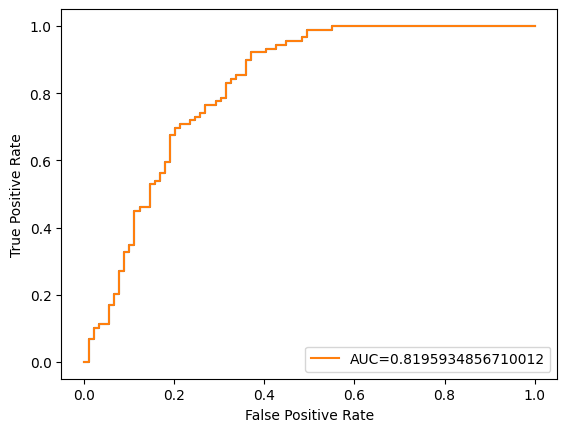

In [46]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [47]:
dict_result[disease] = [fpr, tpr, auc]

In [48]:
X_train = df_train[['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
# y = np.array(df.loc[rows_sel, 'y'])
y_train = np.array(df_train['y'])

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X_train)

X_train = imp.transform(X_train)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_test = df_test[['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
X_test = np.array(X_test)
X_test = imp.transform(X_test)
X_test = scaler.transform(X_test)
y_test = np.array(df_test['y'])

model.fit(X_train,y_train)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


LogisticRegression()

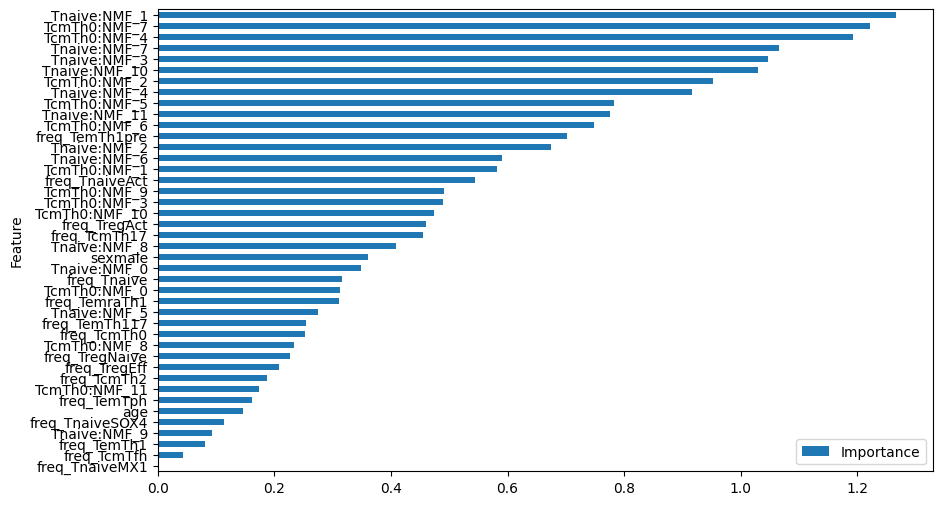

In [49]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': ['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale'], 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
dict_fi[disease] = feature_importance

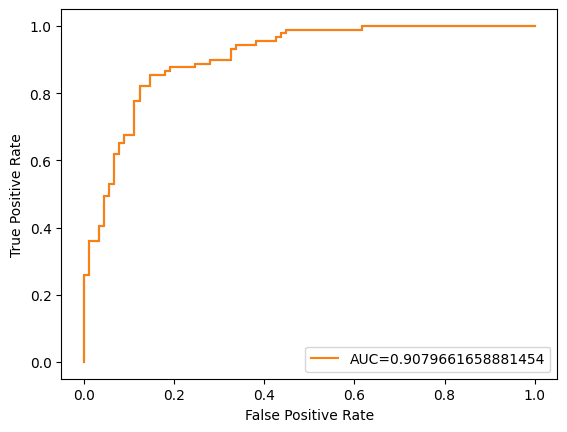

In [50]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [51]:
dict_result_nmf[disease] = [fpr, tpr, auc]

In [52]:
X_train = df_train[list_nmf_col_use + ['age', 'sexmale']]
# y = np.array(df.loc[rows_sel, 'y'])
y_train = np.array(df_train['y'])

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X_train)

X_train = imp.transform(X_train)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_test = df_test[list_nmf_col_use + ['age', 'sexmale']]
X_test = np.array(X_test)
X_test = imp.transform(X_test)
X_test = scaler.transform(X_test)
y_test = np.array(df_test['y'])

model.fit(X_train,y_train)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


LogisticRegression()

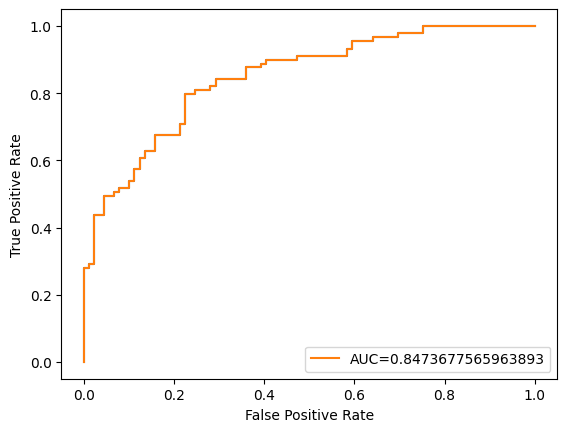

In [53]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [54]:
dict_result_onlynmf[disease] = [fpr, tpr, auc]

## MS

In [55]:
disease = 'MS'

In [56]:
df[df['disease'] == disease].project.value_counts()

GSE144744    31
GSE133028    12
GSE138266     5
ours          4
Name: project, dtype: int64

In [57]:
df_train = pd.concat([df[(df.project.isin(['GSE144744', 'ours'])) & (df.disease.isin(['HC', disease]))],
                      df[(df.project=='GSE174188')&(df.disease=='HC')].iloc[:-96]])
df_test = pd.concat([df[df.project.isin(['GSE133028', 'GSE138266'])],
                    df[(df.project=='GSE194315')&(df.disease=='HC')].iloc[:-20]
                    ])

In [58]:
# check sample duplications
assert df_train.index.duplicated().sum() == 0
assert df_test.index.duplicated().sum() == 0
assert len(set(df_train.index) & set(df_test.index)) == 0

In [59]:
df_train.disease.value_counts()

MS    35
HC    35
Name: disease, dtype: int64

In [60]:
df_test.disease.value_counts()

MS    17
HC    17
Name: disease, dtype: int64

In [61]:
df_train['y'] = (df_train.disease == disease) * 1
df_test['y'] = (df_test.disease == disease) * 1

X_train = df_train[['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
X_train = np.array(X_train)
y_train = np.array(df_train.loc[:, 'y'])

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_test = df_test[['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
y_test = np.array(df_test.loc[:, 'y'])

X_test = scaler.transform(X_test)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [62]:
model.fit(X_train,y_train)

LogisticRegression()

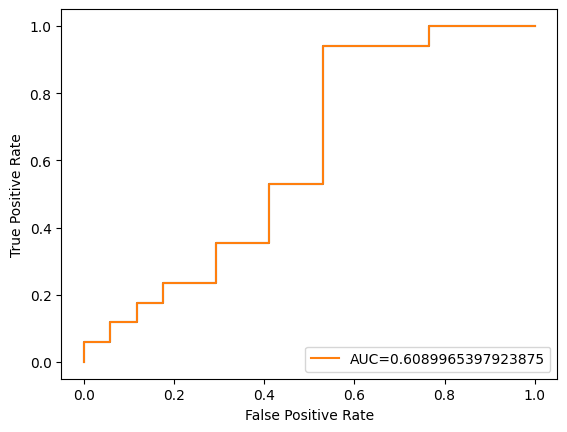

In [63]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [64]:
dict_result[disease] = [fpr, tpr, auc]

In [65]:
X_train = df_train[['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
# y = np.array(df.loc[rows_sel, 'y'])
y_train = np.array(df_train['y'])

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X_train)

X_train = imp.transform(X_train)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_test = df_test[['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
X_test = np.array(X_test)
X_test = imp.transform(X_test)
X_test = scaler.transform(X_test)
y_test = np.array(df_test['y'])

model.fit(X_train,y_train)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


LogisticRegression()

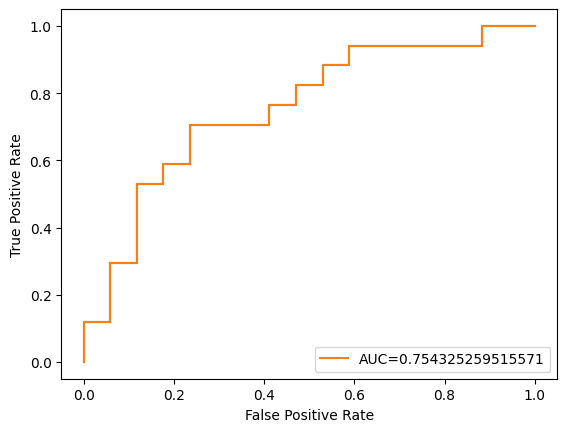

In [66]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

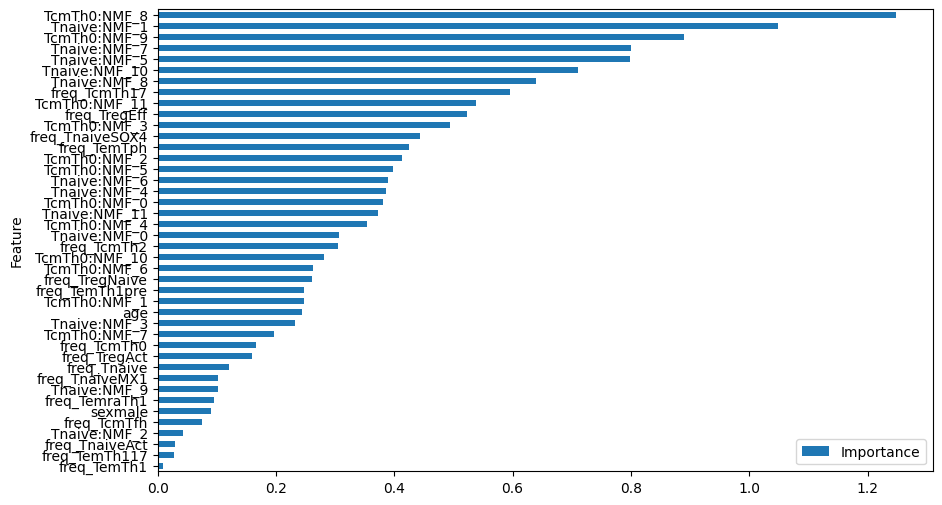

In [67]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': ['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale'], 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
dict_fi[disease] = feature_importance

In [68]:
dict_result_nmf[disease] = [fpr, tpr, auc]

In [69]:
X_train = df_train[list_nmf_col_use + ['age', 'sexmale']]
# y = np.array(df.loc[rows_sel, 'y'])
y_train = np.array(df_train['y'])

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X_train)

X_train = imp.transform(X_train)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_test = df_test[list_nmf_col_use + ['age', 'sexmale']]
X_test = np.array(X_test)
X_test = imp.transform(X_test)
X_test = scaler.transform(X_test)
y_test = np.array(df_test['y'])

model.fit(X_train,y_train)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


LogisticRegression()

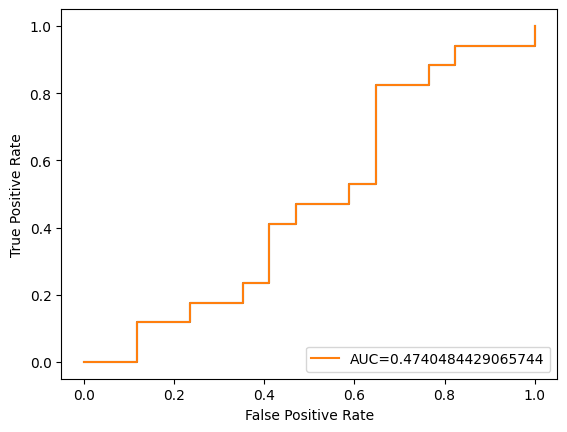

In [70]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [71]:
dict_result_onlynmf[disease] = [fpr, tpr, auc]

## combine results

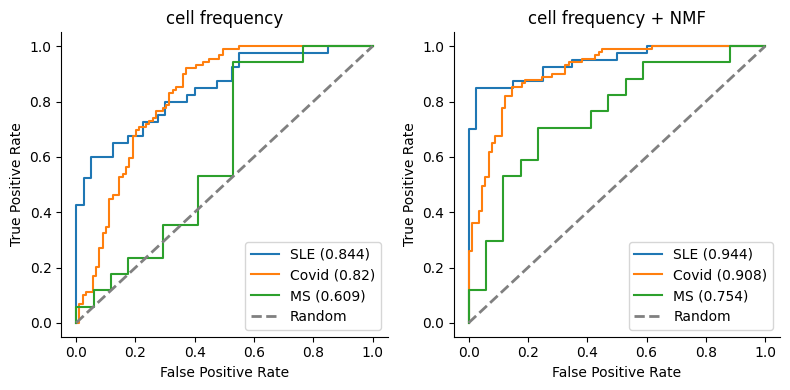

In [72]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
for k,v in dict_result.items():
    #create ROC curve
    plt.plot(v[0],v[1],label=k + " ({})".format(round(v[2], 3)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Random')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.title('cell frequency')
sns.despine()

plt.subplot(1,2,2)
for k,v in dict_result_nmf.items():
    #create ROC curve
    plt.plot(v[0],v[1],label=k + " ({})".format(round(v[2], 3)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Random')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.title('cell frequency + NMF')
sns.despine()

plt.tight_layout()
plt.savefig('../scanpy/{}'.format(version) + '/ROC_binary.pdf', bbox_inches='tight')

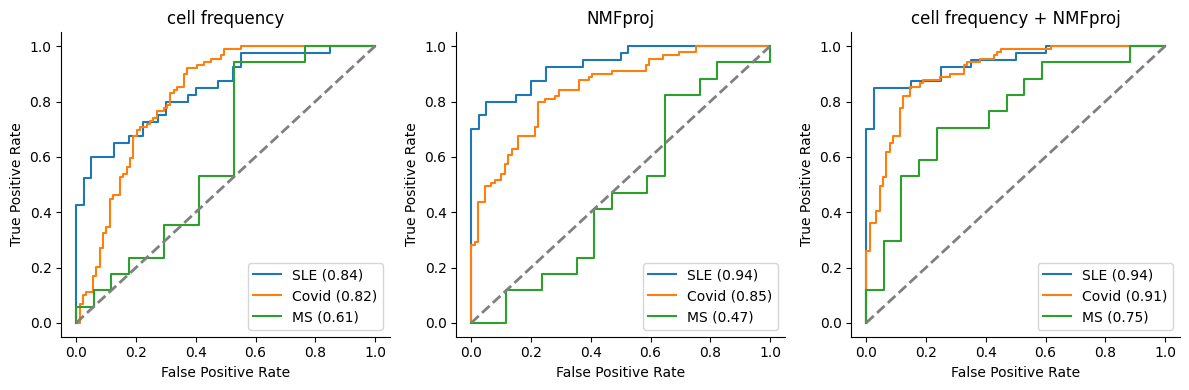

In [73]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
for k,v in dict_result.items():
    #create ROC curve
    plt.plot(v[0],v[1],label=k + " ({})".format(round(v[2], 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.title('cell frequency')
sns.despine()

plt.subplot(1,3,2)
for k,v in dict_result_onlynmf.items():
    #create ROC curve
    plt.plot(v[0],v[1],label=k + " ({})".format(round(v[2], 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.title('NMFproj')
sns.despine()


plt.subplot(1,3,3)
for k,v in dict_result_nmf.items():
    #create ROC curve
    plt.plot(v[0],v[1],label=k + " ({})".format(round(v[2], 2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.title('cell frequency + NMFproj')
sns.despine()

plt.tight_layout()
plt.savefig('../scanpy/{}'.format(version) + '/ROC_binary_all.pdf', bbox_inches='tight')

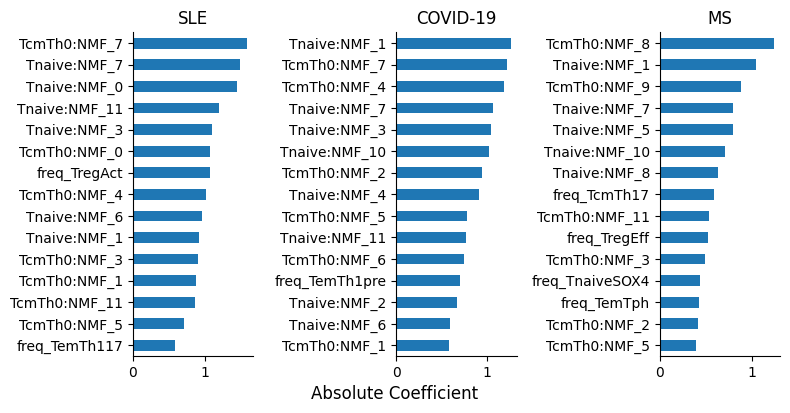

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,4))

dict_fi['SLE'].iloc[-15:].plot(x='Feature', y='Importance', kind='barh', ax=axes[0])
axes[0].get_legend().remove()
axes[0].set_title('SLE')
axes[0].set_ylabel(None)
dict_fi['Covid'].iloc[-15:].plot(x='Feature', y='Importance', kind='barh', ax=axes[1])
axes[1].get_legend().remove()
axes[1].set_title('COVID-19')
axes[1].set_ylabel(None)
dict_fi['MS'].iloc[-15:].plot(x='Feature', y='Importance', kind='barh', ax=axes[2])
axes[2].get_legend().remove()
axes[2].set_title('MS')
axes[2].set_ylabel(None)
plt.tight_layout()
fig.supxlabel("Absolute Coefficient", y=-0.02)
sns.despine()
plt.savefig('../scanpy/{}'.format(version) + '/featureimportance_binary_all.pdf', bbox_inches='tight')

## select diseases

In [75]:
df_train = df[~df.project.isin(list_proj_test)]
df_test = df[df.project.isin(list_proj_test)]

In [76]:
df_train['disease'].value_counts()

HC                  263
SLE                 156
Covid               116
Psoriasis            62
MS                   43
Sarcoidosis          27
RA                   20
T1D                  11
Celiac               11
ParkinsonDisease      8
PPP                   7
UC                    7
Kawasaki              6
pSS                   5
Neurosarcoidosis      5
Flu                   5
CD                    4
BD                    4
Tuberculosis          3
AD                    3
Name: disease, dtype: int64

In [77]:
df_test['disease'].value_counts()

Covid    89
HC       43
SLE      43
MS        9
MG        3
Name: disease, dtype: int64

In [78]:
df_train = df_train[df_train.disease.isin(list(df_train['disease'].value_counts()[df_train['disease'].value_counts() >= th_n_dis].index))]

In [79]:
y = df_train['disease'].factorize()[0]
df_train['y'] = y

df_test = df_test[df_test.disease.isin(df_train.disease)]
y_test = [list(df_train['disease'].factorize()[1]).index(x) for x in df_test['disease']]
df_test['y'] = y_test

In [80]:
df_train['disease'].value_counts()

HC             263
SLE            156
Covid          116
Psoriasis       62
MS              43
Sarcoidosis     27
RA              20
Celiac          11
T1D             11
Name: disease, dtype: int64

In [81]:
df_test['disease'].value_counts()

Covid    89
HC       43
SLE      43
MS        9
Name: disease, dtype: int64

## prediction

In [82]:
num_perm = 500

In [83]:
X = df_train[['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
# X = np.array(X)
# X = df.loc[df_train['project'] != 'ours', ['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
X = np.array(X)
# y = np.array(df.loc[df['project'] != 'ours', 'y'])
y = np.array(df_train.loc[:, 'y'])
# y = LabelEncoder().fit_transform(y)

In [84]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [85]:
oversample = SMOTE(sampling_strategy='all')
# oversample = SMOTE(sampling_strategy={i:162 if i != 0 else 220 for i in range(y.max()+1)})
X, y = oversample.fit_resample(X, y)

In [86]:
pd.Series([df_train['disease'].factorize()[1][x] for x in y]).value_counts()

HC             263
Sarcoidosis    263
Psoriasis      263
Celiac         263
MS             263
RA             263
SLE            263
Covid          263
T1D            263
dtype: int64

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.75925
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.51408
[3]	valid_0's multi_logloss: 1.3416
[4]	valid_0's multi_logloss: 1.2034
[5]	valid_0's multi_logloss: 1.09451
[6]	valid_0's multi_logloss: 1.0029
[7]	valid_0's multi_logloss: 0.923285
[8]	valid_0's multi_logloss: 0.854185
[9]	valid_0's multi_logloss: 0.796594
[10]	valid_0's multi_logloss: 0.746736
[11]	valid_0's multi_logloss: 0.703881
[12]	valid_0's multi_logloss: 0.666201
[13]	valid_0's multi_logloss: 0.631193
[14]	valid_0's multi_logloss: 0.601842
[15]	valid_0's multi_logloss: 0.574377
[16]	valid_0's multi_logloss: 0.550255
[17]	valid_0's multi_logloss: 0.529079
[18]	valid_0's multi_logloss: 0.509764
[19]	valid_0's multi_logloss: 0.49207
[20]	valid_0's multi_logloss: 0.475168
[21]	valid_0's multi_logloss: 0.46119
[22]	valid_0's multi_logloss: 0.44609
[23]	valid_0's multi_logloss: 0.433247
[24]	valid_0's multi_logloss: 0.421103
[25]	valid_0's multi_log

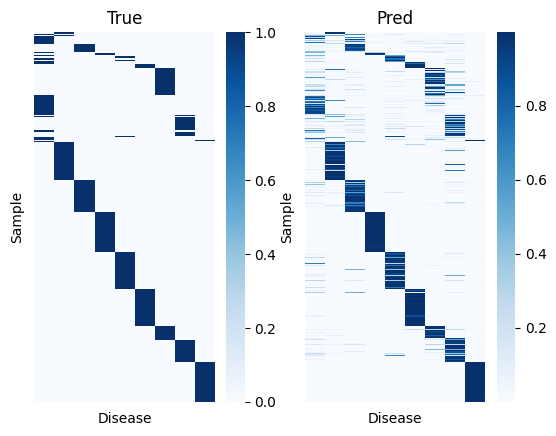

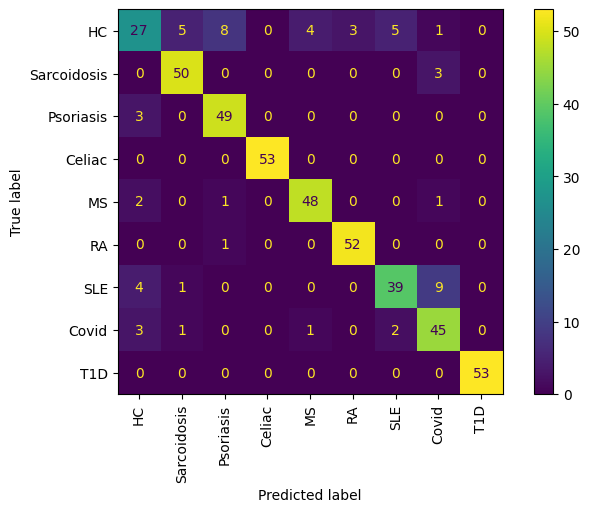

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.768
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.53512
[3]	valid_0's multi_logloss: 1.36117
[4]	valid_0's multi_logloss: 1.23366
[5]	valid_0's multi_logloss: 1.12105
[6]	valid_0's multi_logloss: 1.02483
[7]	valid_0's multi_logloss: 0.946009
[8]	valid_0's multi_logloss: 0.88183
[9]	valid_0's multi_logloss: 0.824973
[10]	valid_0's multi_logloss: 0.777822
[11]	valid_0's multi_logloss: 0.730827
[12]	valid_0's multi_logloss: 0.689445
[13]	valid_0's multi_logloss: 0.652594
[14]	valid_0's multi_logloss: 0.622833
[15]	valid_0's multi_logloss: 0.593362
[16]	valid_0's multi_logloss: 0.56839
[17]	valid_0's multi_logloss: 0.546689
[18]	valid_0's multi_logloss: 0.526259
[19]	valid_0's multi_logloss: 0.507204
[20]	valid_0's multi_logloss: 0.492317
[21]	valid_0's multi_logloss: 0.474339
[22]	valid_0's multi_logloss: 0.461642
[23]	valid_0's multi_logloss: 0.447307
[24]	valid_0's multi_logloss: 0.438862
[25]	valid_0's multi_l

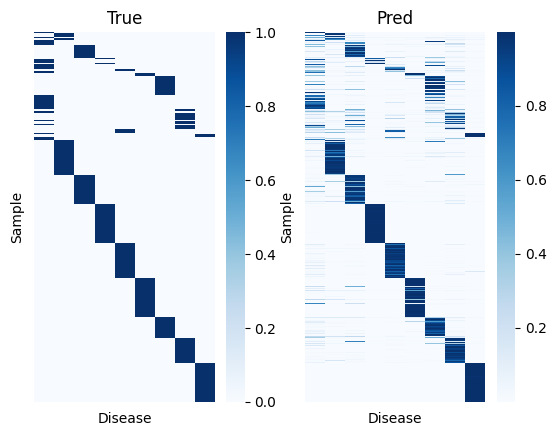

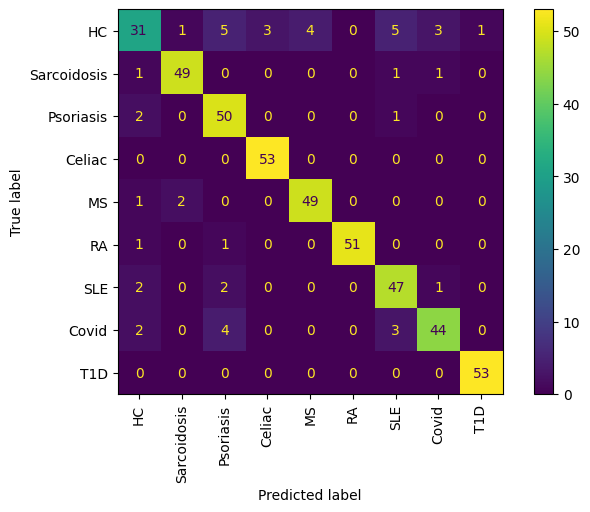

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.78897
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.56276
[3]	valid_0's multi_logloss: 1.38708
[4]	valid_0's multi_logloss: 1.25009
[5]	valid_0's multi_logloss: 1.14462
[6]	valid_0's multi_logloss: 1.05155
[7]	valid_0's multi_logloss: 0.974746
[8]	valid_0's multi_logloss: 0.911143
[9]	valid_0's multi_logloss: 0.854003
[10]	valid_0's multi_logloss: 0.804712
[11]	valid_0's multi_logloss: 0.762138
[12]	valid_0's multi_logloss: 0.726305
[13]	valid_0's multi_logloss: 0.694464
[14]	valid_0's multi_logloss: 0.664968
[15]	valid_0's multi_logloss: 0.634486
[16]	valid_0's multi_logloss: 0.609728
[17]	valid_0's multi_logloss: 0.590163
[18]	valid_0's multi_logloss: 0.568932
[19]	valid_0's multi_logloss: 0.547585
[20]	valid_0's multi_logloss: 0.529394
[21]	valid_0's multi_logloss: 0.512211
[22]	valid_0's multi_logloss: 0.498451
[23]	valid_0's multi_logloss: 0.486701
[24]	valid_0's multi_logloss: 0.478481
[25]	valid_0's mul

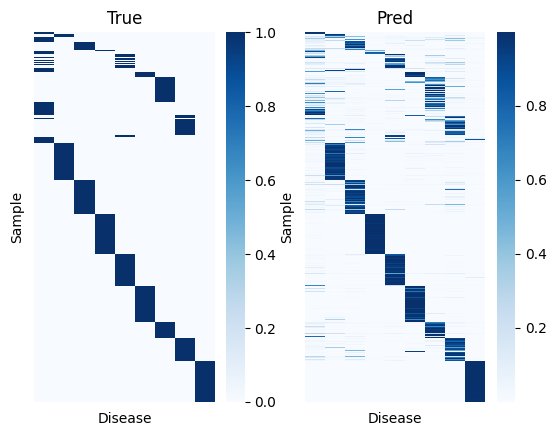

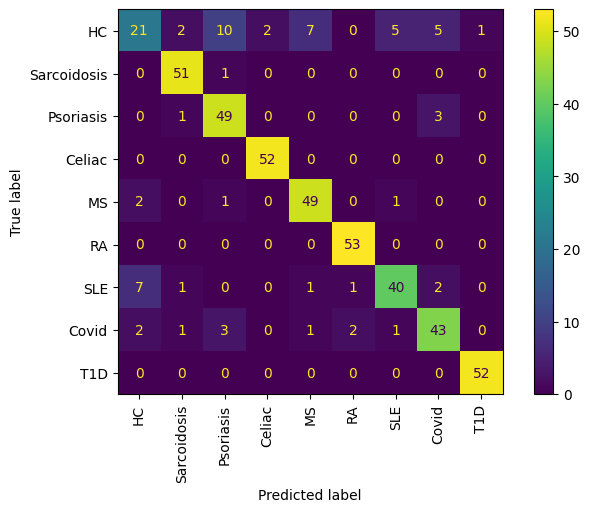

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.78299
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.55317
[3]	valid_0's multi_logloss: 1.38018
[4]	valid_0's multi_logloss: 1.23954
[5]	valid_0's multi_logloss: 1.13027
[6]	valid_0's multi_logloss: 1.02958
[7]	valid_0's multi_logloss: 0.953117
[8]	valid_0's multi_logloss: 0.890079
[9]	valid_0's multi_logloss: 0.834261
[10]	valid_0's multi_logloss: 0.778973
[11]	valid_0's multi_logloss: 0.737325
[12]	valid_0's multi_logloss: 0.701618
[13]	valid_0's multi_logloss: 0.667394
[14]	valid_0's multi_logloss: 0.637344
[15]	valid_0's multi_logloss: 0.610513
[16]	valid_0's multi_logloss: 0.586016
[17]	valid_0's multi_logloss: 0.564497
[18]	valid_0's multi_logloss: 0.549412
[19]	valid_0's multi_logloss: 0.532785
[20]	valid_0's multi_logloss: 0.5137
[21]	valid_0's multi_logloss: 0.497142
[22]	valid_0's multi_logloss: 0.482377
[23]	valid_0's multi_logloss: 0.468571
[24]	valid_0's multi_logloss: 0.456776
[25]	valid_0's multi

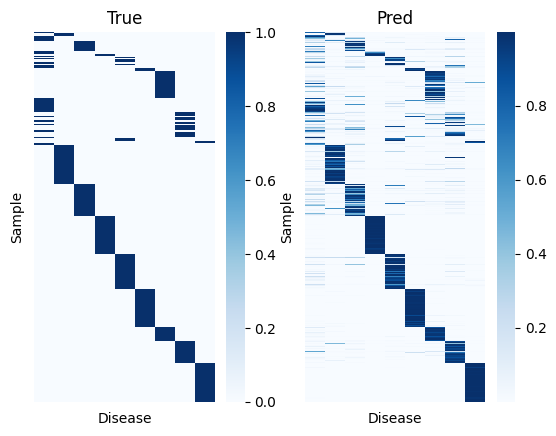

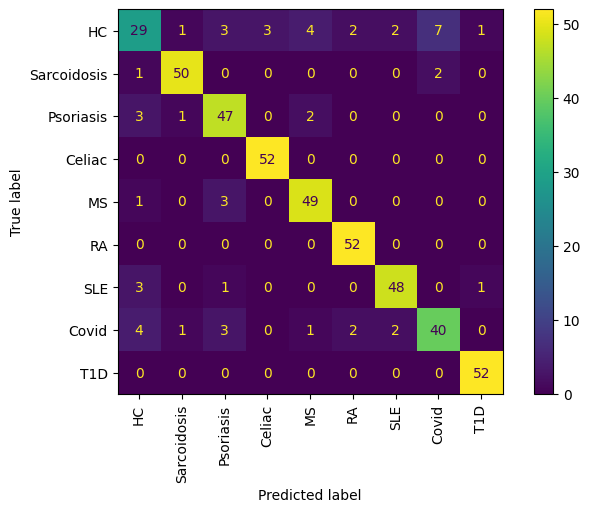

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.75687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.50219
[3]	valid_0's multi_logloss: 1.32955
[4]	valid_0's multi_logloss: 1.19104
[5]	valid_0's multi_logloss: 1.0752
[6]	valid_0's multi_logloss: 0.982356
[7]	valid_0's multi_logloss: 0.909693
[8]	valid_0's multi_logloss: 0.842562
[9]	valid_0's multi_logloss: 0.781849
[10]	valid_0's multi_logloss: 0.729025
[11]	valid_0's multi_logloss: 0.680285
[12]	valid_0's multi_logloss: 0.639601
[13]	valid_0's multi_logloss: 0.605153
[14]	valid_0's multi_logloss: 0.570785
[15]	valid_0's multi_logloss: 0.540584
[16]	valid_0's multi_logloss: 0.514457
[17]	valid_0's multi_logloss: 0.489532
[18]	valid_0's multi_logloss: 0.467025
[19]	valid_0's multi_logloss: 0.448002
[20]	valid_0's multi_logloss: 0.428628
[21]	valid_0's multi_logloss: 0.412179
[22]	valid_0's multi_logloss: 0.397573
[23]	valid_0's multi_logloss: 0.389152
[24]	valid_0's multi_logloss: 0.37747
[25]	valid_0's mult

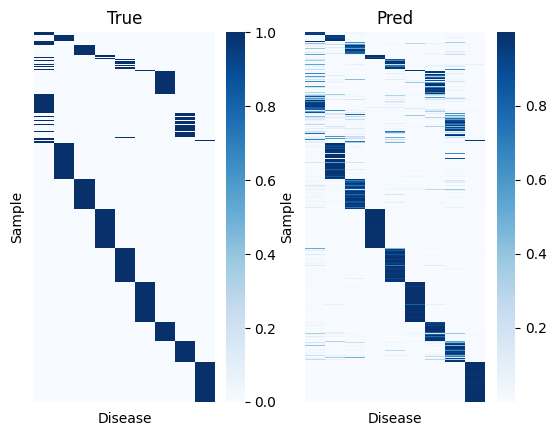

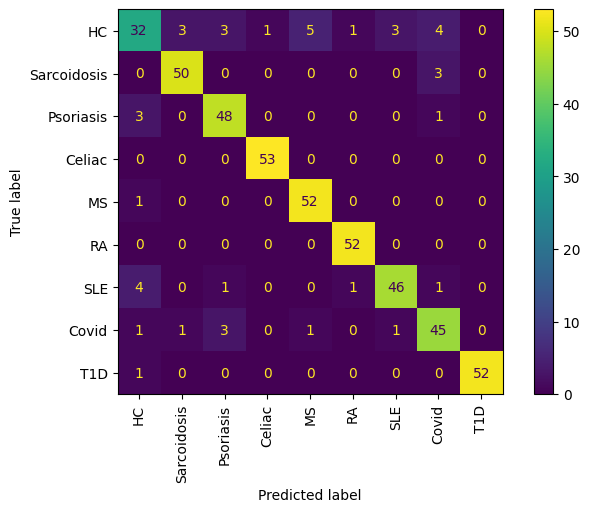

CV score: 0.3323178225875054


In [87]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import numpy as np

FOLD = 5
NUM_ROUND = 40
VERBOSE_EVAL = 1
NUM_CLASS = y.max() + 1

# params = {
#     'objective': 'multiclass',
#     'verbose': -1,
#     'num_class': NUM_CLASS,
#     'early_stopping_rounds':10,
#     'max_depth': 5,
#     'num_leaves': 10,
#     'reg_alpha' : .1,
#     'reg_beta' : .1,
#     'colsample_bytree' : 0.3,
#     'subsample' : 0.4,
#     'min_child_samples' : 30,
#     'learning_rate':0.04
# }
params = {
    'objective': 'multiclass',
    'verbose': -1,
    'num_class': NUM_CLASS,
    'early_stopping_rounds':10,
    
}

valid_scores = []
valid_auc = []
valid_ap = []
models = []
kf = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(X, y)):
    X_train, X_valid = X[train_indices], X[valid_indices]
    y_train, y_valid = y[train_indices], y[valid_indices]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=NUM_ROUND,
        verbose_eval=VERBOSE_EVAL
    )

    y_valid_pred = model.predict(X_valid)
#     score = log_loss(y_valid, y_valid_pred)
    score = log_loss(np.identity(NUM_CLASS)[y_valid], y_valid_pred)
    print(f'fold {fold} log loss: {score}')
    valid_scores.append(score)
    
    ap = []
    for i in range(NUM_CLASS):
        ap.append(average_precision_score(np.identity(NUM_CLASS)[y_valid][:, i], y_valid_pred[:, i]))
    valid_ap.append(ap)
    
    models.append(model)
    
    f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
    sns.heatmap(np.identity(NUM_CLASS)[y_valid], cmap='Blues', ax=ax1)
    ax1.set_title('True')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_ylabel('Sample')
    ax1.set_xlabel('Disease')

    sns.heatmap(y_valid_pred, cmap='Blues', ax=ax2)
    ax2.set_title('Pred')
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax2.set_ylabel('Sample')
    ax2.set_xlabel('Disease')
    
    cmat = confusion_matrix(y_valid, np.argmax(y_valid_pred, axis=1), labels=range(NUM_CLASS))
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        cmat,
        display_labels=df_train['disease'].factorize()[1],
    )

    cmp.plot(ax=ax, xticks_rotation='vertical')
    # ax.set_xticklabels(ax.get_xticks(), rotation = 90)
    plt.show();
    
    if fold == 0:
        conf_mat = cmat
    else:
        conf_mat += cmat

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

In [88]:
df_ap = pd.DataFrame(valid_ap, columns=df_train['disease'].factorize()[1]).T
df_ap

0         1         2         3         4
HC           0.753748  0.649768  0.640456  0.708822  0.793110
Sarcoidosis  0.989036  0.989030  0.989598  0.979208  0.988605
Psoriasis    0.973932  0.963380  0.939715  0.944686  0.968472
Celiac       1.000000  0.997928  0.999288  0.999637  1.000000
MS           0.988125  0.987061  0.976136  0.956541  0.994226
RA           0.990626  0.996058  0.994791  0.998951  1.000000
SLE          0.910129  0.908455  0.893986  0.954635  0.969026
Covid        0.937611  0.962292  0.903617  0.879323  0.909501
T1D          1.000000  0.996595  1.000000  1.000000  0.999651

In [89]:
df_ap.mean(axis=1)

HC             0.709181
Sarcoidosis    0.987095
Psoriasis      0.958037
Celiac         0.999370
MS             0.980418
RA             0.996085
SLE            0.927246
Covid          0.918468
T1D            0.999249
dtype: float64

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


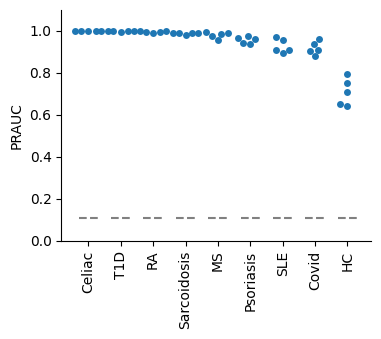

In [90]:
df_ap_melt = df_ap.reset_index().melt(id_vars='index').dropna()
id_oreder = df_ap_melt.groupby(by='index').mean().sort_values(by='value', ascending=False).index

df_ap_exp = pd.DataFrame(index=df_ap.index)
df_ap_exp['exp'] = list(pd.Series(y).value_counts()[range(NUM_CLASS)] / y.shape[0])
df_ap_exp = df_ap_exp.loc[id_oreder]
df_ap_exp['pos'] = range(NUM_CLASS)

plt.figure(figsize=(4,3))
sns.swarmplot(data=df_ap_melt, x='index', y='value', order=id_oreder)
for pos,row in df_ap_exp.iterrows():
    plt.hlines(row['exp'], row['pos']-0.3, row['pos']+0.3, colors='grey', linestyles='--')
plt.xticks(rotation=90)
plt.ylabel('PRAUC')
plt.xlabel(None)
plt.ylim(0,1.1)
sns.despine()

In [91]:
pd.Series(y).value_counts()[range(NUM_CLASS)]

0    263
1    263
2    263
3    263
4    263
5    263
6    263
7    263
8    263
dtype: int64

In [92]:
df_ap_exp

exp  pos
index                     
Celiac       0.111111    0
T1D          0.111111    1
RA           0.111111    2
Sarcoidosis  0.111111    3
MS           0.111111    4
Psoriasis    0.111111    5
SLE          0.111111    6
Covid        0.111111    7
HC           0.111111    8

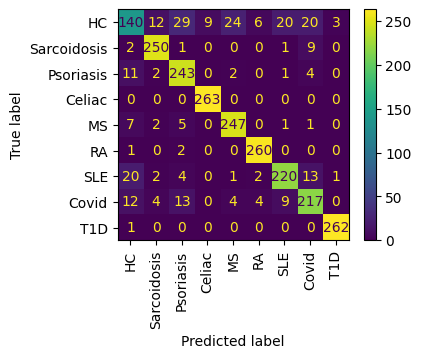

In [93]:
fig, ax = plt.subplots(figsize=(4, 3))
cmp = ConfusionMatrixDisplay(
    conf_mat,
    display_labels=df_train['disease'].factorize()[1],
)

cmp.plot(ax=ax, xticks_rotation='vertical')
# ax.set_xticklabels(ax.get_xticks(), rotation = 90)
plt.show();

Text(0.5, 23.52222222222222, 'Disease')

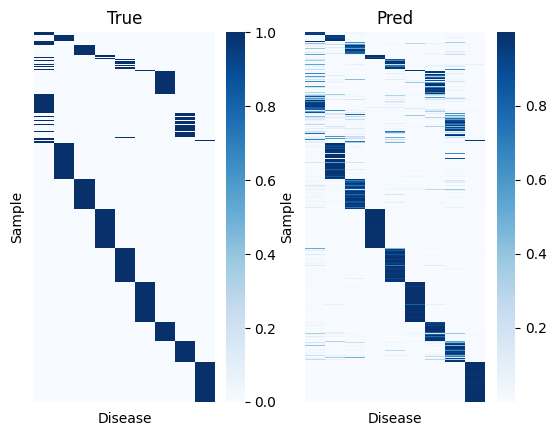

In [94]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
sns.heatmap(np.identity(NUM_CLASS)[y_valid], cmap='Blues', ax=ax1)
ax1.set_title('True')
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_ylabel('Sample')
ax1.set_xlabel('Disease')

sns.heatmap(y_valid_pred, cmap='Blues', ax=ax2)
ax2.set_title('Pred')
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_ylabel('Sample')
ax2.set_xlabel('Disease')

In [95]:
df_conf = pd.DataFrame(conf_mat, columns=df_train['disease'].factorize()[1], index=df_train['disease'].factorize()[1])
df_conf.head()

HC  Sarcoidosis  Psoriasis  Celiac   MS  RA  SLE  Covid  T1D
HC           140           12         29       9   24   6   20     20    3
Sarcoidosis    2          250          1       0    0   0    1      9    0
Psoriasis     11            2        243       0    2   0    1      4    0
Celiac         0            0          0     263    0   0    0      0    0
MS             7            2          5       0  247   0    1      1    0

In [96]:
df_conf

HC  Sarcoidosis  Psoriasis  Celiac   MS   RA  SLE  Covid  T1D
HC           140           12         29       9   24    6   20     20    3
Sarcoidosis    2          250          1       0    0    0    1      9    0
Psoriasis     11            2        243       0    2    0    1      4    0
Celiac         0            0          0     263    0    0    0      0    0
MS             7            2          5       0  247    0    1      1    0
RA             1            0          2       0    0  260    0      0    0
SLE           20            2          4       0    1    2  220     13    1
Covid         12            4         13       0    4    4    9    217    0
T1D            1            0          0       0    0    0    0      0  262

In [97]:
df_conf.columns

Index(['HC', 'Sarcoidosis', 'Psoriasis', 'Celiac', 'MS', 'RA', 'SLE', 'Covid',
       'T1D'],
      dtype='object')

In [98]:
list_hc = ['HC']
list_aid = ['SLE', 'Sarcoidosis', 'Kawasaki',
       'Psoriasis', 'Celiac', 'MS', 'RA']
list_aid = [x for x in list_aid if x in list(df_train['disease'])]
list_cov = ['Covid']

In [99]:
df_conf_sum = pd.DataFrame([[df_conf.loc[df_conf.index.isin(list_hc), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_hc), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_hc), list_cov].sum().sum()],
[df_conf.loc[df_conf.index.isin(list_aid), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_aid), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_aid), list_cov].sum().sum()],
[df_conf.loc[df_conf.index.isin(list_cov), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_cov), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_cov), list_cov].sum().sum()]], index=['HC', 'AID', 'CoV'], columns=['HC', 'AID', 'CoV'])

In [100]:
df_conf_sum

HC   AID  CoV
HC   140   100   20
AID   41  1509   27
CoV   12    34  217

array([<AxesSubplot: ylabel='HC'>, <AxesSubplot: ylabel='AID'>,
       <AxesSubplot: ylabel='CoV'>], dtype=object)

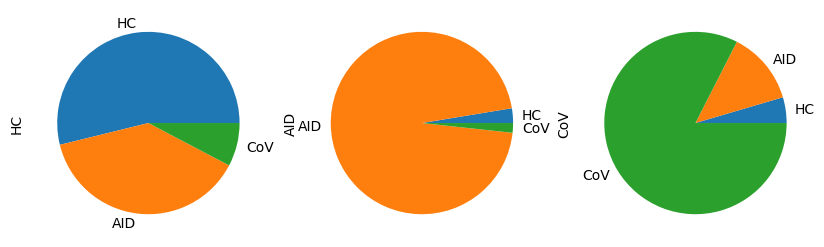

In [101]:
df_conf_sum.T.plot.pie(subplots=True, figsize=(10,4), legend=False)

In [102]:
l = []
for i,m in enumerate(models):
    d_fi = pd.DataFrame(m.feature_importance(), index=['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale'],
                        columns = [i])
    l.append(d_fi)
df_fi = (pd.concat(l, axis=1))

<AxesSubplot: >

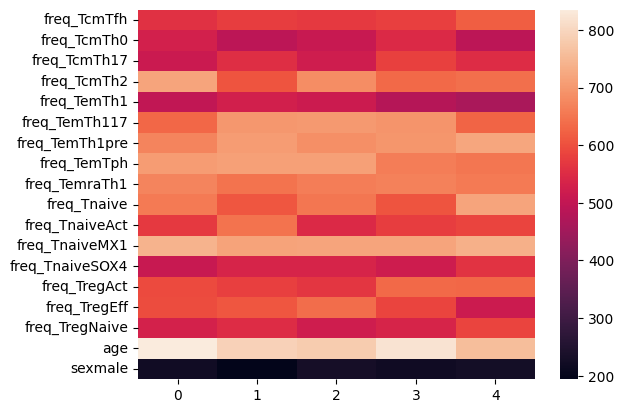

In [103]:
sns.heatmap(df_fi)

<AxesSubplot: >

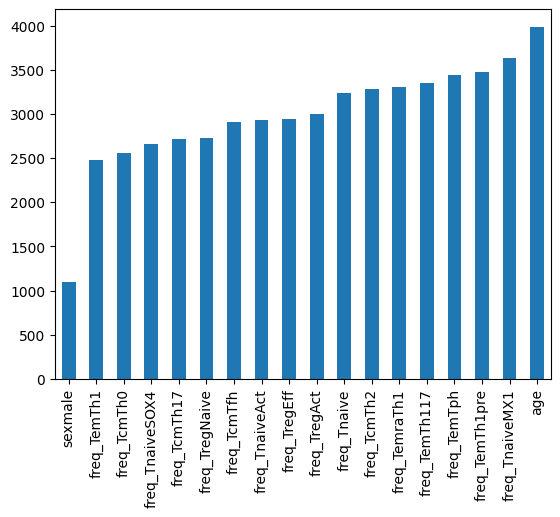

In [104]:
df_fi.sum(axis=1).sort_values().plot.bar()

### test

In [105]:
X_test = df_test[['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
y_test = np.array(df_test.loc[:, 'y'])

In [106]:
X_test = scaler.fit_transform(X_test)

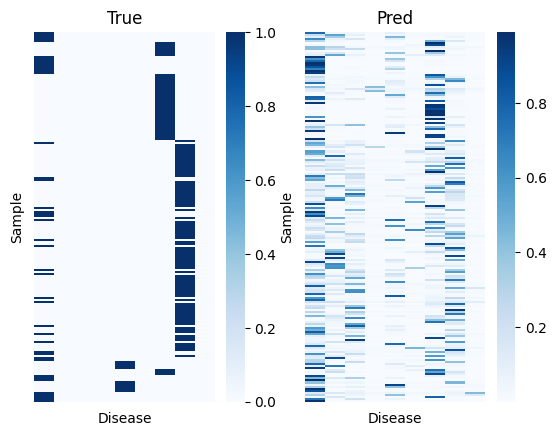

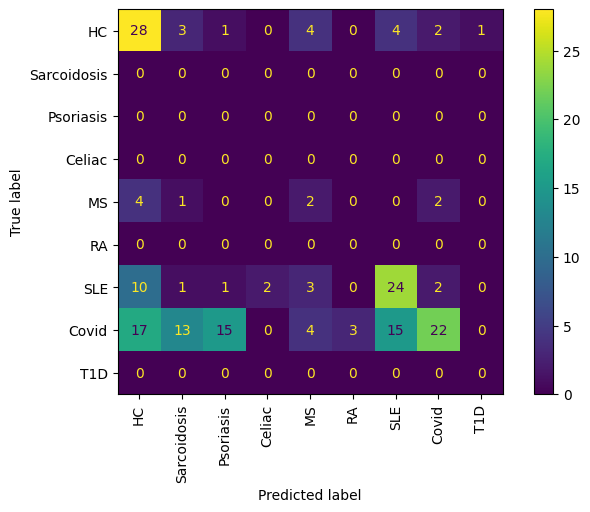

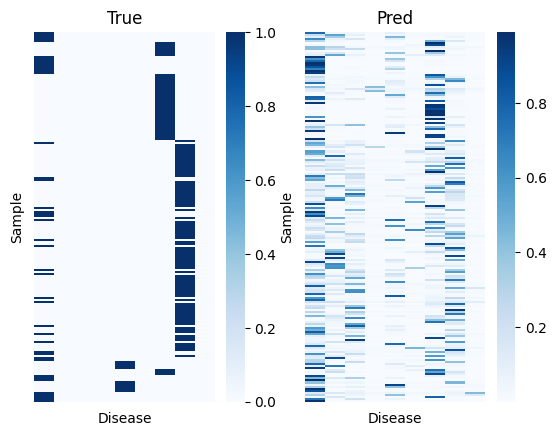

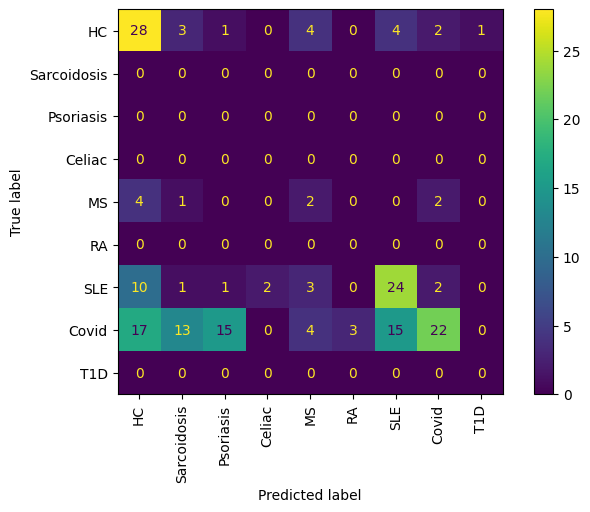

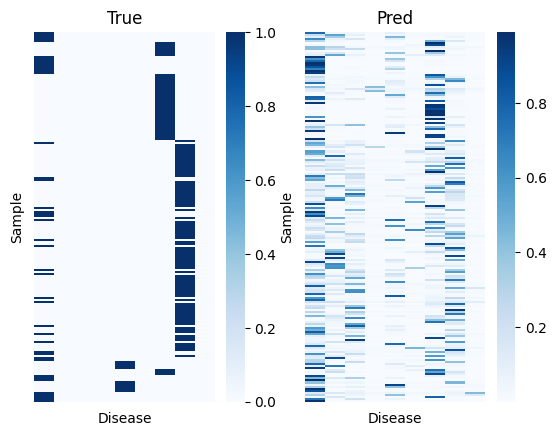

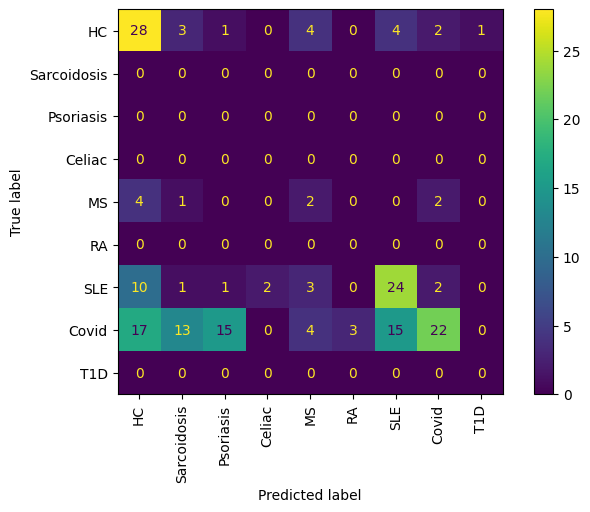

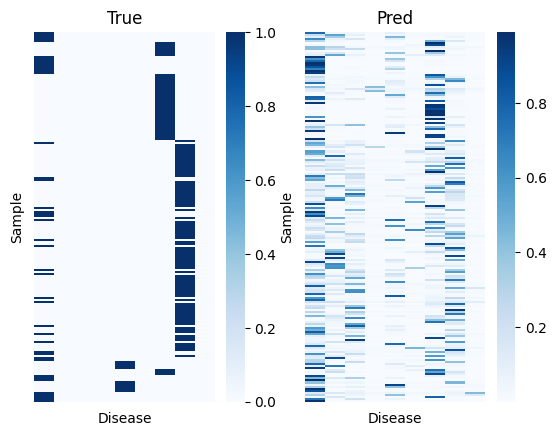

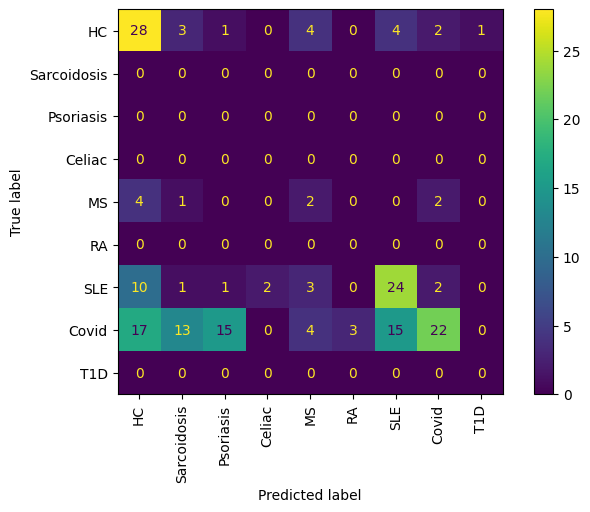

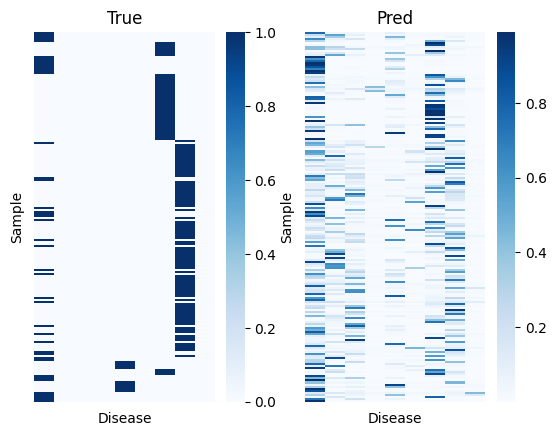

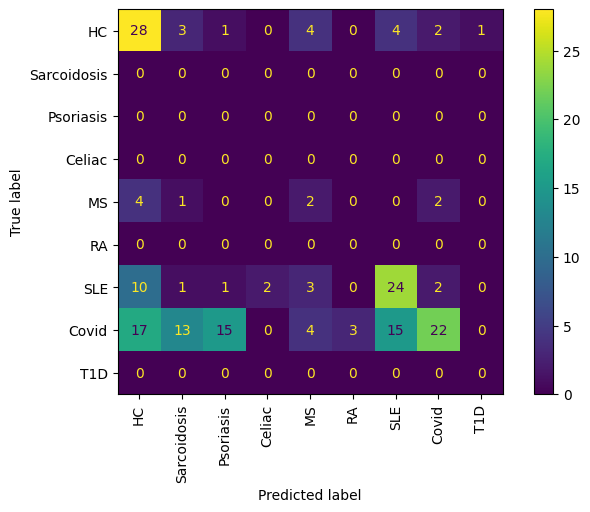

CV score: 0.3323178225875054


In [107]:
for fold in range(FOLD):
    y_test_pred = model.predict(X_test)
    
    f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
    sns.heatmap(np.identity(NUM_CLASS)[y_test], cmap='Blues', ax=ax1)
    ax1.set_title('True')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_ylabel('Sample')
    ax1.set_xlabel('Disease')

    sns.heatmap(y_test_pred, cmap='Blues', ax=ax2)
    ax2.set_title('Pred')
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax2.set_ylabel('Sample')
    ax2.set_xlabel('Disease')
    
    cmat = confusion_matrix(y_test, np.argmax(y_test_pred, axis=1), labels=range(NUM_CLASS))
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        cmat,
        display_labels=df_train['disease'].factorize()[1],
    )

    cmp.plot(ax=ax, xticks_rotation='vertical')
    # ax.set_xticklabels(ax.get_xticks(), rotation = 90)
    plt.show();
    
    if fold == 0:
        conf_mat = cmat
    else:
        conf_mat += cmat

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

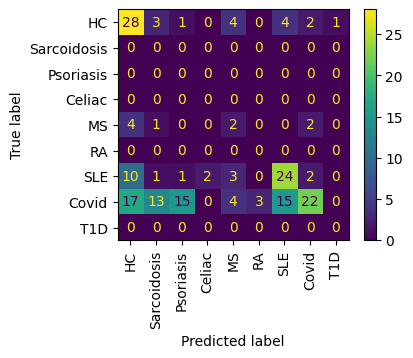

In [108]:
for fold in range(FOLD):
    _y_test_pred = model.predict(X_test)
    if fold == 0:
        y_test_pred = _y_test_pred
    else:
        y_test_pred += _y_test_pred
y_test_pred /= FOLD

cmat = confusion_matrix(y_test, np.argmax(y_test_pred, axis=1), labels=range(NUM_CLASS))
fig, ax = plt.subplots(figsize=(4, 3))
cmp = ConfusionMatrixDisplay(
    cmat,
    display_labels=df_train['disease'].factorize()[1],
)

cmp.plot(ax=ax, xticks_rotation='vertical')
# ax.set_xticklabels(ax.get_xticks(), rotation = 90)

plt.savefig('../scanpy/{}'.format(version) + '/confusionmatrix_withoutNMF.pdf', bbox_inches='tight')
plt.show();

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall i

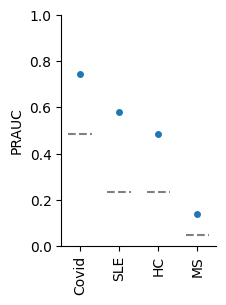

In [110]:
test_ap = []
for i in range(NUM_CLASS):
    test_ap.append(average_precision_score(np.identity(NUM_CLASS)[y_test][:, i], y_test_pred[:, i]))
    
df_ap = pd.DataFrame([test_ap], columns=df_train['disease'].factorize()[1]).T
df_ap = df_ap.iloc[list(set(y_test))]
df_ap_melt = df_ap.reset_index().melt(id_vars='index').dropna()
id_order = df_ap_melt.groupby(by='index').mean().sort_values(by='value', ascending=False).index

df_ap_exp = pd.DataFrame(pd.Series(y_test).value_counts() / len(y_test), columns=['exp'])
df_ap_exp.index = [df_train['disease'].factorize()[1][x] for x in df_ap_exp.index]
df_ap_exp = df_ap_exp.loc[id_order]
df_ap_exp['pos'] = range(df_ap_exp.shape[0])

plt.figure(figsize=(2,3))
sns.swarmplot(data=df_ap_melt, x='index', y='value', order=id_order)
for pos,row in df_ap_exp.iterrows():
    plt.hlines(row['exp'], row['pos']-0.3, row['pos']+0.3, colors='grey', linestyles='--')
plt.xticks(rotation=90)
plt.ylabel('PRAUC')
plt.xlabel(None)
plt.ylim(0,1)
sns.despine()

plt.savefig('../scanpy/{}'.format(version) + '/PRAUC_withoutNMF.pdf', bbox_inches='tight')

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall i

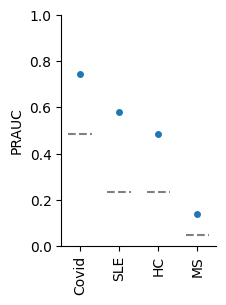

In [111]:
test_ap = []
for i in range(NUM_CLASS):
    test_ap.append(average_precision_score(np.identity(NUM_CLASS)[y_test][:, i], y_test_pred[:, i]))
    
df_ap = pd.DataFrame([test_ap], columns=df_train['disease'].factorize()[1]).T
df_ap = df_ap.iloc[list(set(y_test))]
df_ap_melt = df_ap.reset_index().melt(id_vars='index').dropna()
id_order = df_ap_melt.groupby(by='index').mean().sort_values(by='value', ascending=False).index

df_ap_exp = pd.DataFrame(pd.Series(y_test).value_counts() / len(y_test), columns=['exp'])
df_ap_exp.index = [df_train['disease'].factorize()[1][x] for x in df_ap_exp.index]
df_ap_exp = df_ap_exp.loc[id_order]
df_ap_exp['pos'] = range(df_ap_exp.shape[0])

plt.figure(figsize=(2,3))
sns.swarmplot(data=df_ap_melt, x='index', y='value', order=id_order)
for pos,row in df_ap_exp.iterrows():
    plt.hlines(row['exp'], row['pos']-0.3, row['pos']+0.3, colors='grey', linestyles='--')
plt.xticks(rotation=90)
plt.ylabel('PRAUC')
plt.xlabel(None)
plt.ylim(0,1)
sns.despine()

plt.savefig('../scanpy/{}'.format(version) + '/PRAUC_withoutNMF.pdf', bbox_inches='tight')

In [112]:
test_ap_shuf = []
y_test_shuf = y_test.copy()
for _ in range(num_perm):
    np.random.shuffle(y_test_shuf)
    t_ap_shuf = []
    for i in range(NUM_CLASS):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            t_ap_shuf.append(average_precision_score(np.identity(NUM_CLASS)[y_test_shuf][:, i], y_test_pred[:, i]))
    test_ap_shuf.append(t_ap_shuf)
df_ap_shuf = pd.DataFrame(test_ap_shuf, columns=df_train['disease'].factorize()[1]).T
df_ap_shuf = df_ap_shuf.loc[id_order]

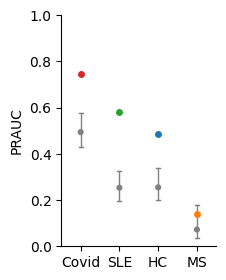

In [113]:
plt.figure(figsize=(2,3))
sns.swarmplot(data=df_ap_melt, x='index', y='value', hue='index', order=id_order, legend=False)
# sns.violinplot(df_ap_shuf.T)
sns.pointplot(df_ap_shuf.T,                   
              estimator= np.mean,
              errorbar=('pi', 95),
                  capsize=.1,
              errwidth=1,
              n_boot=1,
              scale=.5,
                  join=False,
                  color='grey',)

plt.ylabel('PRAUC')
plt.xlabel(None)
plt.ylim(0,1)
sns.despine()

plt.savefig('../scanpy/{}'.format(version) + f'/PRAUC_withoutNMF_n_perm{num_perm}_pi95.pdf', bbox_inches='tight')

In [114]:
df_ap

0
HC     0.486065
MS     0.139297
SLE    0.580745
Covid  0.746502

In [115]:
df_ap_melt

index variable     value
0     HC        0  0.486065
1     MS        0  0.139297
2    SLE        0  0.580745
3  Covid        0  0.746502

In [116]:
accuracy_score(y_test, np.argmax(y_test_pred, axis=1))

0.41304347826086957

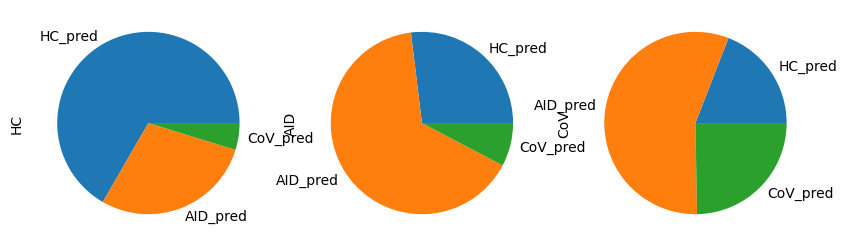

In [117]:
df_conf = pd.DataFrame(conf_mat, columns=df_train['disease'].factorize()[1], index=df_train['disease'].factorize()[1])
# df_conf.head()

df_conf_sum = pd.DataFrame([[df_conf.loc[df_conf.index.isin(list_hc), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_hc), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_hc), list_cov].sum().sum()],
[df_conf.loc[df_conf.index.isin(list_aid), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_aid), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_aid), list_cov].sum().sum()],
[df_conf.loc[df_conf.index.isin(list_cov), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_cov), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_cov), list_cov].sum().sum()]], index=['HC', 'AID', 'CoV'], columns=['HC_pred', 'AID_pred', 'CoV_pred'])

df_conf_sum.T.plot.pie(subplots=True, figsize=(10,4), legend=False)


plt.savefig('../scanpy/{}'.format(version) + '/pie_withoutNMF.pdf', bbox_inches='tight')

## with NMF

In [118]:
# list_nmf_col_use = list(df_NMF_piv.loc[:,df_NMF_piv.columns.str.split(':').str.get(0).isin(['TcmTfh', 'TcmTh0', 'TcmTh17',
#                                                                                             'TcmTh2', 'TemTh1', 'TemTh117',
#        'TemTh1pre',  'TemraTh1', 'Tnaive', 'TregAct', 'TregEff'])].columns)
# list_nmf_col_use = list(df_NMF_piv.loc[:,df_NMF_piv.columns.str.split(':').str.get(0).isin(['TcmTh0','Tnaive', 'TregAct', 'TregEff'])].columns)
list_nmf_col_use = list(df_NMF_piv.loc[:,df_NMF_piv.columns.str.split(':').str.get(0).isin(['Tnaive', 'TcmTh0'])].columns)
# list_nmf_col_use = df_NMF_piv.columns

In [119]:
# X = df[['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
# X = np.array(X)
# X = df.loc[(df['project'] != 'ours') & (df[list_nmf_col_use].isna().sum(axis=1) == 0), 
#            ['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
# X = np.array(X)
# y = np.array(df.loc[(df['project'] != 'ours') & (df[list_nmf_col_use].isna().sum(axis=1) == 0), 'y'])

# rows_sel = (df[list_nmf_col_use].isna().sum(axis=1) == 0)

# X = df.loc[rows_sel, 
#            ['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
X = df_train[['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
# y = np.array(df.loc[rows_sel, 'y'])
y = np.array(df_train['y'])

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X)

X = imp.transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

<AxesSubplot: ylabel='sample'>

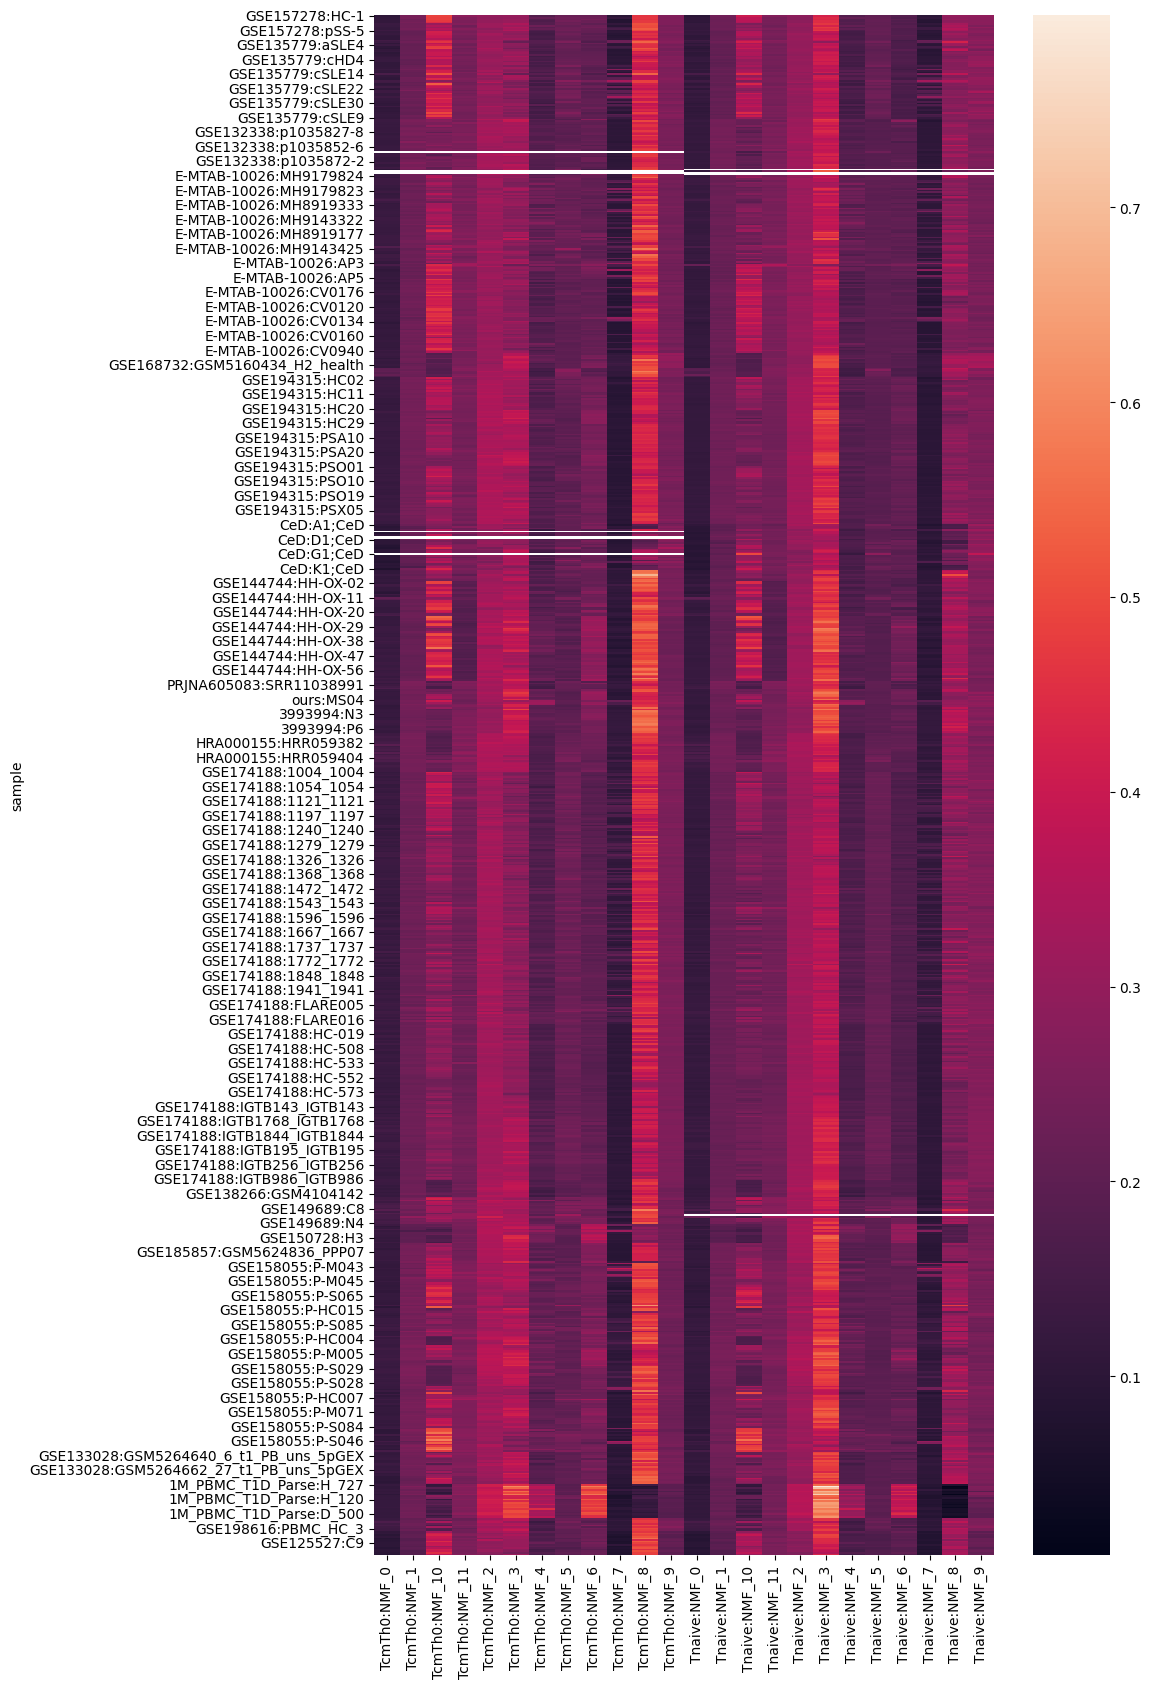

In [120]:
plt.figure(figsize=(10,20))
sns.heatmap(df[list_nmf_col_use])

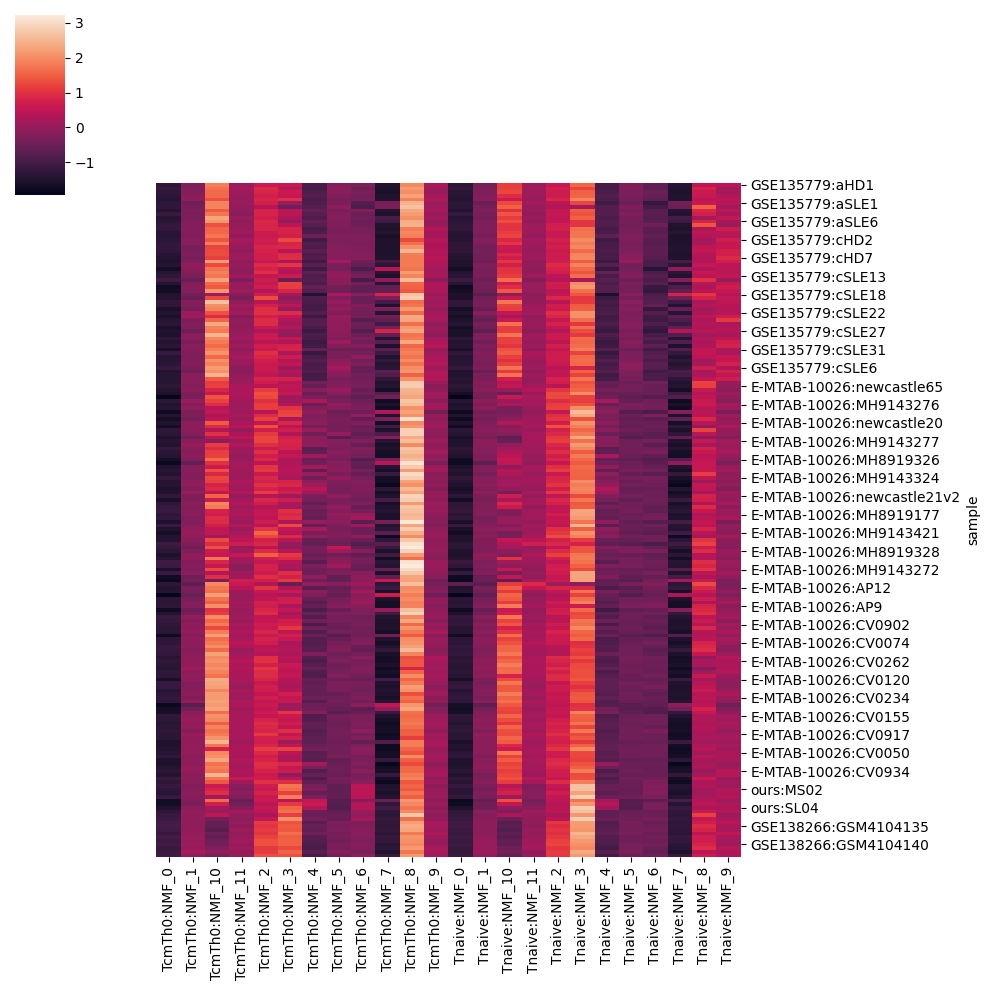

In [121]:
sns.clustermap(df_test[list_nmf_col_use], z_score=0, col_cluster=False, row_cluster=False)

In [122]:
oversample = SMOTE(sampling_strategy='all')
# oversample = SMOTE(sampling_strategy={i:162 if i != 0 else 220 for i in range(y.max()+1)})
X, y = oversample.fit_resample(X, y)

In [123]:
pd.Series([df['disease'].factorize()[1][x] for x in y]).value_counts()

HC             263
pSS            263
SLE            263
Sarcoidosis    263
Covid          263
Kawasaki       263
CD             263
Psoriasis      263
Celiac         263
dtype: int64

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.62422
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.33489
[3]	valid_0's multi_logloss: 1.12645
[4]	valid_0's multi_logloss: 0.963731
[5]	valid_0's multi_logloss: 0.836416
[6]	valid_0's multi_logloss: 0.740028
[7]	valid_0's multi_logloss: 0.65886
[8]	valid_0's multi_logloss: 0.590101
[9]	valid_0's multi_logloss: 0.5333
[10]	valid_0's multi_logloss: 0.484224
[11]	valid_0's multi_logloss: 0.440968
[12]	valid_0's multi_logloss: 0.403615
[13]	valid_0's multi_logloss: 0.37372
[14]	valid_0's multi_logloss: 0.347199
[15]	valid_0's multi_logloss: 0.326086
[16]	valid_0's multi_logloss: 0.30632
[17]	valid_0's multi_logloss: 0.289085
[18]	valid_0's multi_logloss: 0.274692
[19]	valid_0's multi_logloss: 0.260689
[20]	valid_0's multi_logloss: 0.250301
[21]	valid_0's multi_logloss: 0.238829
[22]	valid_0's multi_logloss: 0.229779
[23]	valid_0's multi_logloss: 0.221243
[24]	valid_0's multi_logloss: 0.215087
[25]	valid_0's multi

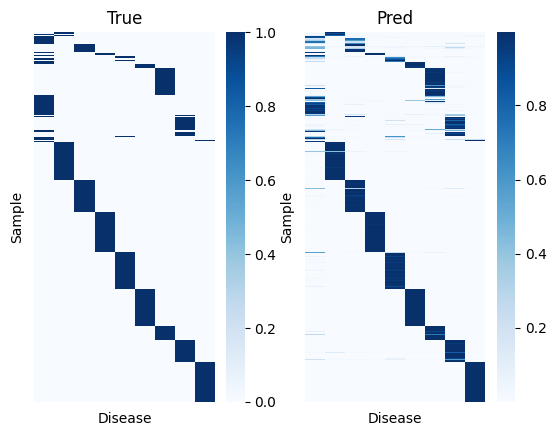

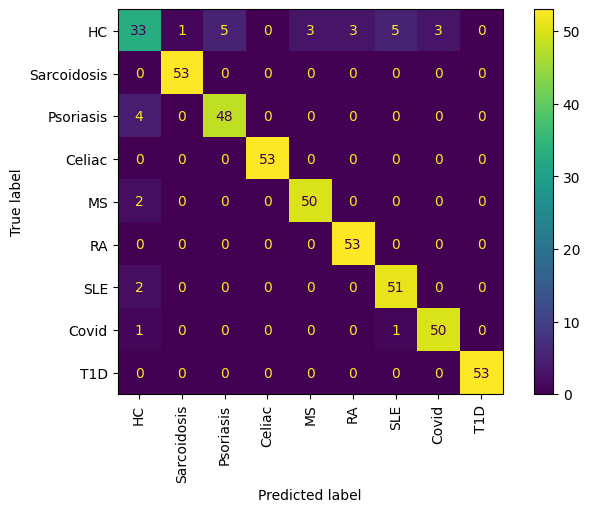

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.62659
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.33372
[3]	valid_0's multi_logloss: 1.13109
[4]	valid_0's multi_logloss: 0.975581
[5]	valid_0's multi_logloss: 0.852151
[6]	valid_0's multi_logloss: 0.754811
[7]	valid_0's multi_logloss: 0.673809
[8]	valid_0's multi_logloss: 0.606441
[9]	valid_0's multi_logloss: 0.548203
[10]	valid_0's multi_logloss: 0.497444
[11]	valid_0's multi_logloss: 0.455138
[12]	valid_0's multi_logloss: 0.417097
[13]	valid_0's multi_logloss: 0.384814
[14]	valid_0's multi_logloss: 0.357382
[15]	valid_0's multi_logloss: 0.335072
[16]	valid_0's multi_logloss: 0.31583
[17]	valid_0's multi_logloss: 0.298294
[18]	valid_0's multi_logloss: 0.281485
[19]	valid_0's multi_logloss: 0.26905
[20]	valid_0's multi_logloss: 0.256267
[21]	valid_0's multi_logloss: 0.247987
[22]	valid_0's multi_logloss: 0.238102
[23]	valid_0's multi_logloss: 0.231218
[24]	valid_0's multi_logloss: 0.225483
[25]	valid_0's mu

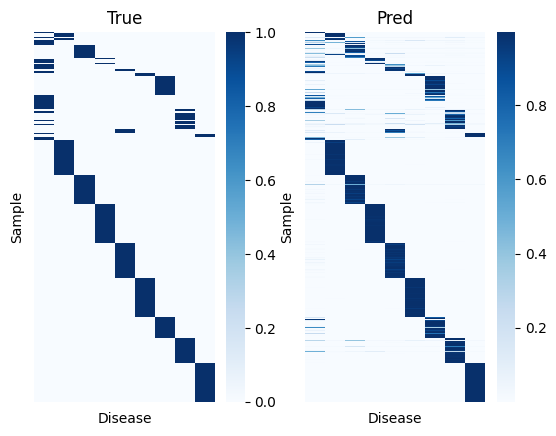

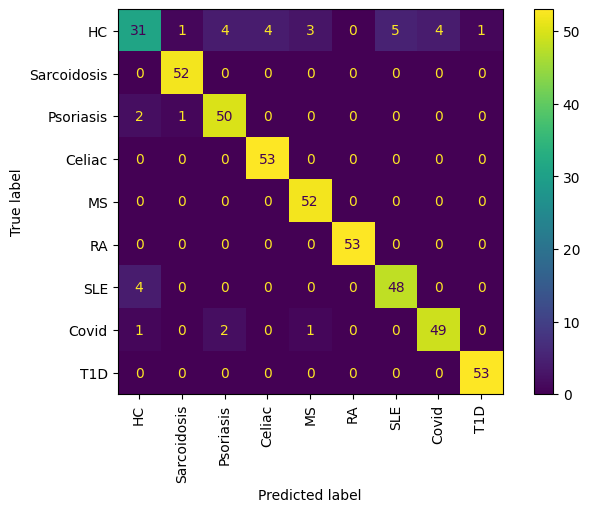

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.61526
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.32388
[3]	valid_0's multi_logloss: 1.1253
[4]	valid_0's multi_logloss: 0.966204
[5]	valid_0's multi_logloss: 0.845355
[6]	valid_0's multi_logloss: 0.742738
[7]	valid_0's multi_logloss: 0.659937
[8]	valid_0's multi_logloss: 0.589868
[9]	valid_0's multi_logloss: 0.530317
[10]	valid_0's multi_logloss: 0.480027
[11]	valid_0's multi_logloss: 0.436161
[12]	valid_0's multi_logloss: 0.397641
[13]	valid_0's multi_logloss: 0.36602
[14]	valid_0's multi_logloss: 0.337521
[15]	valid_0's multi_logloss: 0.313728
[16]	valid_0's multi_logloss: 0.295456
[17]	valid_0's multi_logloss: 0.277524
[18]	valid_0's multi_logloss: 0.261269
[19]	valid_0's multi_logloss: 0.249531
[20]	valid_0's multi_logloss: 0.23689
[21]	valid_0's multi_logloss: 0.228845
[22]	valid_0's multi_logloss: 0.219428
[23]	valid_0's multi_logloss: 0.213361
[24]	valid_0's multi_logloss: 0.208172
[25]	valid_0's mul

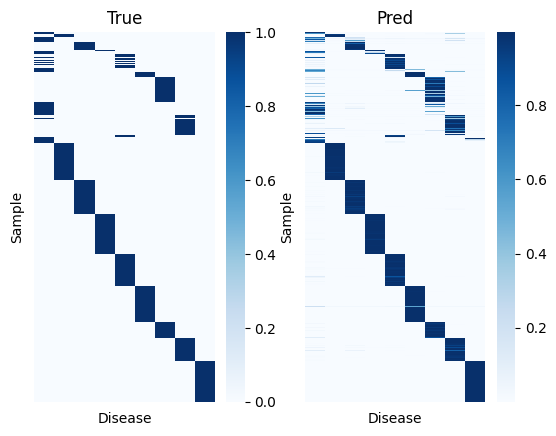

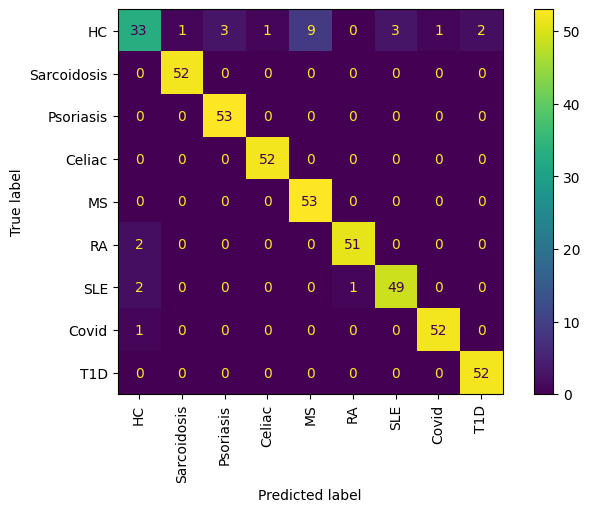

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.60936
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.31505
[3]	valid_0's multi_logloss: 1.11035
[4]	valid_0's multi_logloss: 0.957506
[5]	valid_0's multi_logloss: 0.835599
[6]	valid_0's multi_logloss: 0.737062
[7]	valid_0's multi_logloss: 0.655888
[8]	valid_0's multi_logloss: 0.590532
[9]	valid_0's multi_logloss: 0.536438
[10]	valid_0's multi_logloss: 0.487438
[11]	valid_0's multi_logloss: 0.446268
[12]	valid_0's multi_logloss: 0.41359
[13]	valid_0's multi_logloss: 0.383049
[14]	valid_0's multi_logloss: 0.357768
[15]	valid_0's multi_logloss: 0.336667
[16]	valid_0's multi_logloss: 0.316862
[17]	valid_0's multi_logloss: 0.29732
[18]	valid_0's multi_logloss: 0.281852
[19]	valid_0's multi_logloss: 0.268525
[20]	valid_0's multi_logloss: 0.255652
[21]	valid_0's multi_logloss: 0.246755
[22]	valid_0's multi_logloss: 0.236823
[23]	valid_0's multi_logloss: 0.22822
[24]	valid_0's multi_logloss: 0.219737
[25]	valid_0's mul

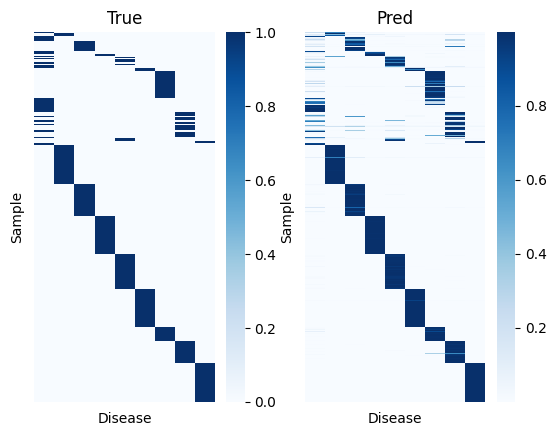

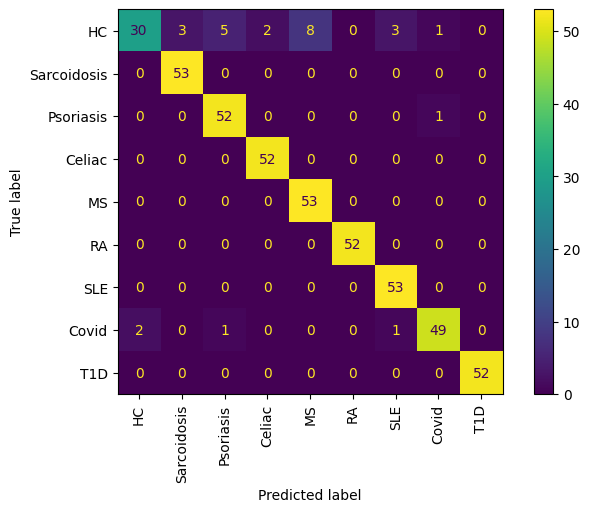

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.62169
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.31843
[3]	valid_0's multi_logloss: 1.11257
[4]	valid_0's multi_logloss: 0.960113
[5]	valid_0's multi_logloss: 0.836994
[6]	valid_0's multi_logloss: 0.738878
[7]	valid_0's multi_logloss: 0.65971
[8]	valid_0's multi_logloss: 0.588435
[9]	valid_0's multi_logloss: 0.530444
[10]	valid_0's multi_logloss: 0.482164
[11]	valid_0's multi_logloss: 0.437452
[12]	valid_0's multi_logloss: 0.401586
[13]	valid_0's multi_logloss: 0.369984
[14]	valid_0's multi_logloss: 0.34171
[15]	valid_0's multi_logloss: 0.319376
[16]	valid_0's multi_logloss: 0.30058
[17]	valid_0's multi_logloss: 0.28527
[18]	valid_0's multi_logloss: 0.271838
[19]	valid_0's multi_logloss: 0.257963
[20]	valid_0's multi_logloss: 0.247192
[21]	valid_0's multi_logloss: 0.235719
[22]	valid_0's multi_logloss: 0.22627
[23]	valid_0's multi_logloss: 0.218344
[24]	valid_0's multi_logloss: 0.212112
[25]	valid_0's multi

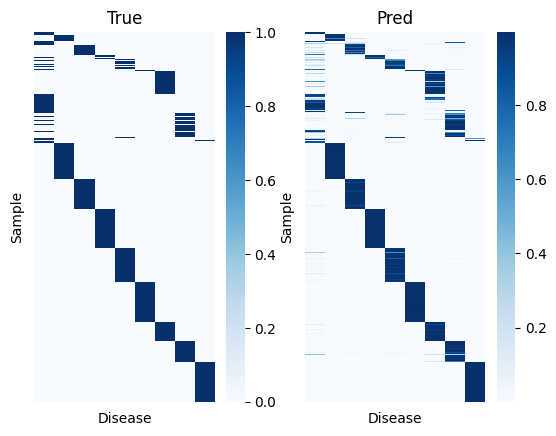

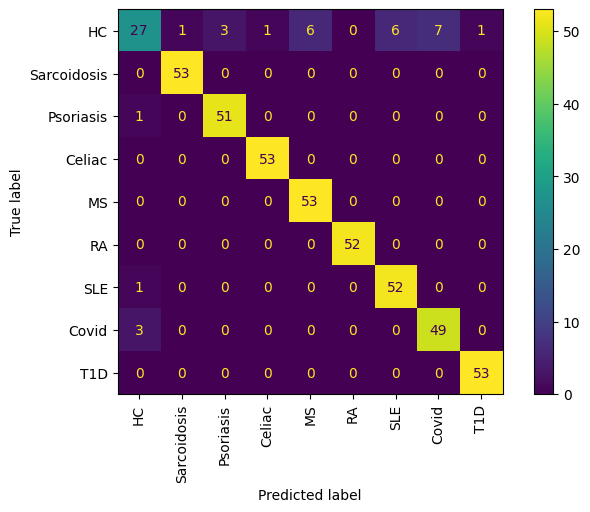

CV score: 0.1809656607373969


In [124]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import numpy as np

valid_scores = []
valid_auc = []
valid_ap = []
models = []
kf = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(X, y)):
    X_train, X_valid = X[train_indices], X[valid_indices]
    y_train, y_valid = y[train_indices], y[valid_indices]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=NUM_ROUND,
        verbose_eval=VERBOSE_EVAL
    )

    y_valid_pred = model.predict(X_valid)
#     score = log_loss(y_valid, y_valid_pred)
    score = log_loss(np.identity(NUM_CLASS)[y_valid], y_valid_pred)
    print(f'fold {fold} log loss: {score}')
    valid_scores.append(score)
    
    ap = []
    for i in range(NUM_CLASS):
        ap.append(average_precision_score(np.identity(NUM_CLASS)[y_valid][:, i], y_valid_pred[:, i]))
    valid_ap.append(ap)
    
    models.append(model)
    
    f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
    sns.heatmap(np.identity(NUM_CLASS)[y_valid], cmap='Blues', ax=ax1)
    ax1.set_title('True')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_ylabel('Sample')
    ax1.set_xlabel('Disease')

    sns.heatmap(y_valid_pred, cmap='Blues', ax=ax2)
    ax2.set_title('Pred')
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax2.set_ylabel('Sample')
    ax2.set_xlabel('Disease')
    
    cmat = confusion_matrix(y_valid, np.argmax(y_valid_pred, axis=1), labels=range(NUM_CLASS))
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        cmat,
        display_labels=df_train['disease'].factorize()[1],
    )

    cmp.plot(ax=ax, xticks_rotation='vertical')
    # ax.set_xticklabels(ax.get_xticks(), rotation = 90)
    plt.show();
    
    if fold == 0:
        conf_mat = cmat
    else:
        conf_mat += cmat

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

In [125]:
df_ap = pd.DataFrame(valid_ap, columns=df_train['disease'].factorize()[1]).T
df_ap

0         1         2         3         4
HC           0.843087  0.825847  0.853703  0.881819  0.822219
Sarcoidosis  0.997799  1.000000  1.000000  0.998989  0.999295
Psoriasis    0.989693  0.982831  0.971886  0.991925  0.994051
Celiac       1.000000  0.996258  1.000000  1.000000  1.000000
MS           0.994744  0.980487  0.986623  0.991924  0.977571
RA           0.995566  1.000000  0.998252  1.000000  1.000000
SLE          0.984917  0.981507  0.994789  0.993174  0.993396
Covid        0.991993  0.989040  0.997443  0.990954  0.970622
T1D          1.000000  0.999295  1.000000  1.000000  1.000000

In [126]:
df_ap.mean(axis=1)

HC             0.845335
Sarcoidosis    0.999217
Psoriasis      0.986077
Celiac         0.999252
MS             0.986270
RA             0.998764
SLE            0.989556
Covid          0.988010
T1D            0.999859
dtype: float64

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


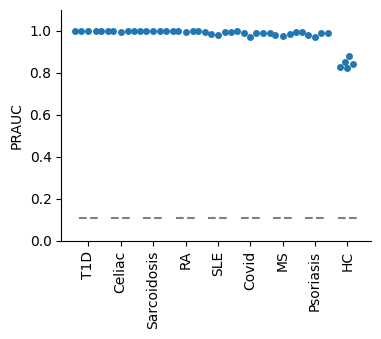

In [127]:
df_ap_melt = df_ap.reset_index().melt(id_vars='index').dropna()
id_oreder = df_ap_melt.groupby(by='index').mean().sort_values(by='value', ascending=False).index

df_ap_exp = pd.DataFrame(index=df_ap.index)
df_ap_exp['exp'] = list(pd.Series(y).value_counts()[range(NUM_CLASS)] / y.shape[0])
df_ap_exp = df_ap_exp.loc[id_oreder]
df_ap_exp['pos'] = range(NUM_CLASS)

plt.figure(figsize=(4,3))
sns.swarmplot(data=df_ap_melt, x='index', y='value', order=id_oreder)
for pos,row in df_ap_exp.iterrows():
    plt.hlines(row['exp'], row['pos']-0.3, row['pos']+0.3, colors='grey', linestyles='--')
plt.xticks(rotation=90)
plt.ylabel('PRAUC')
plt.xlabel(None)
plt.ylim(0,1.1)
sns.despine()

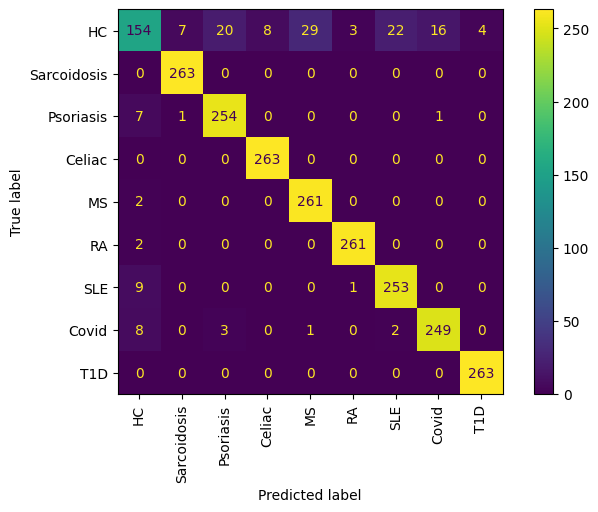

In [128]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    conf_mat,
    display_labels=df_train['disease'].factorize()[1],
)

cmp.plot(ax=ax, xticks_rotation='vertical')
# ax.set_xticklabels(ax.get_xticks(), rotation = 90)
plt.show();

array([<AxesSubplot: ylabel='HC'>, <AxesSubplot: ylabel='AID'>,
       <AxesSubplot: ylabel='CoV'>], dtype=object)

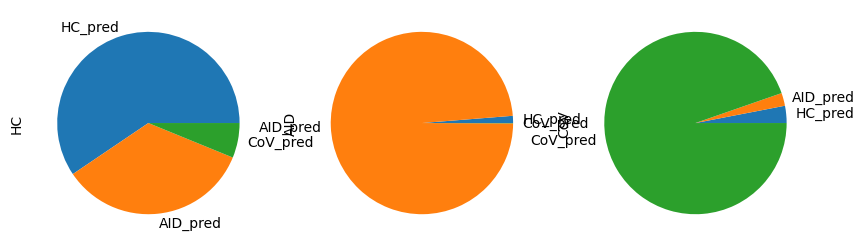

In [129]:
df_conf = pd.DataFrame(conf_mat, columns=df_train['disease'].factorize()[1], index=df_train['disease'].factorize()[1])
# df_conf.head()

df_conf_sum = pd.DataFrame([[df_conf.loc[df_conf.index.isin(list_hc), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_hc), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_hc), list_cov].sum().sum()],
[df_conf.loc[df_conf.index.isin(list_aid), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_aid), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_aid), list_cov].sum().sum()],
[df_conf.loc[df_conf.index.isin(list_cov), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_cov), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_cov), list_cov].sum().sum()]], index=['HC', 'AID', 'CoV'], columns=['HC_pred', 'AID_pred', 'CoV_pred'])

df_conf_sum.T.plot.pie(subplots=True, figsize=(10,4), legend=False)

In [130]:
df_conf_sum

HC_pred  AID_pred  CoV_pred
HC       154        89        16
AID       20      1557         1
CoV        8         6       249

In [131]:
X_test = df_test[['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
X_test = np.array(X_test)
X_test = imp.transform(X_test)
X_test = scaler.fit_transform(X_test)
y_test = np.array(df_test['y'])

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


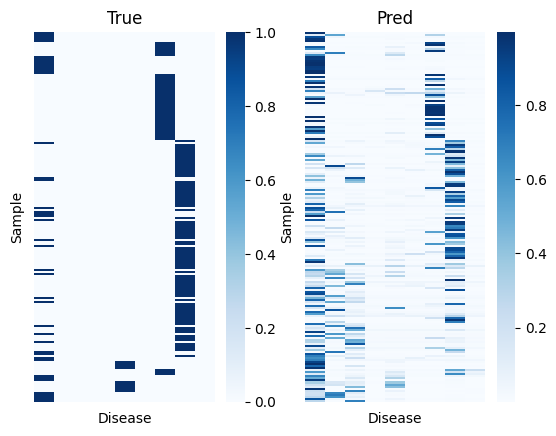

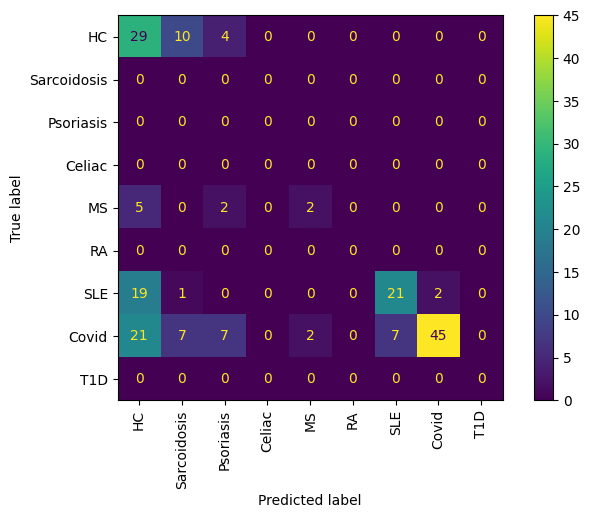

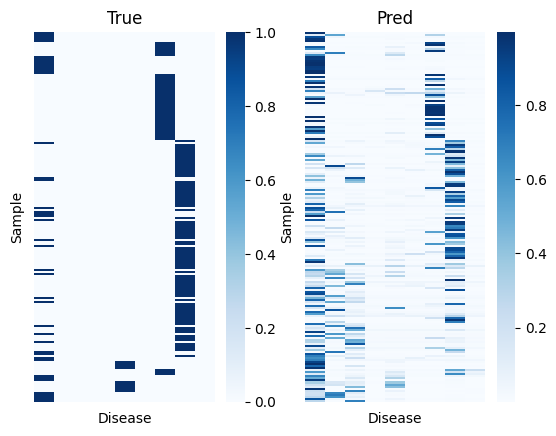

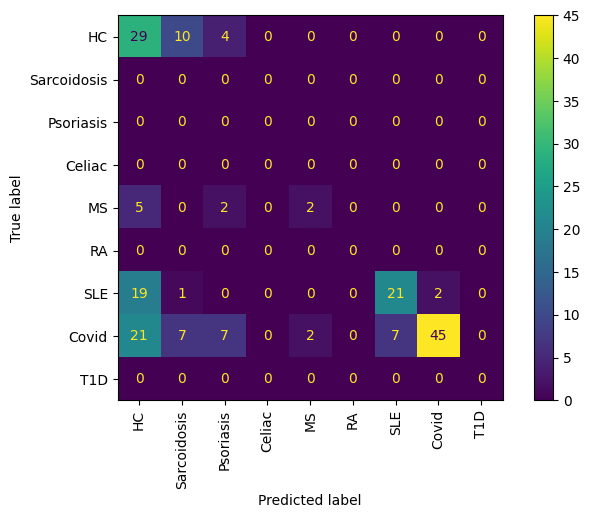

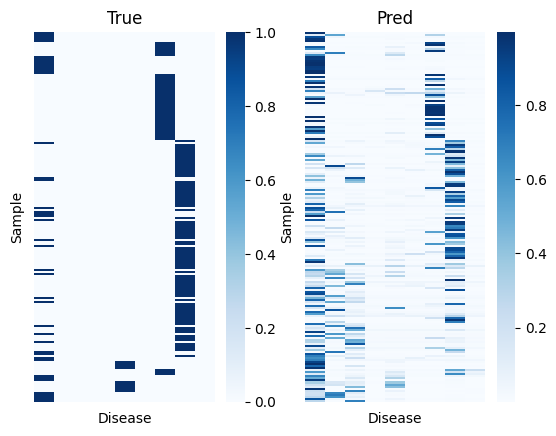

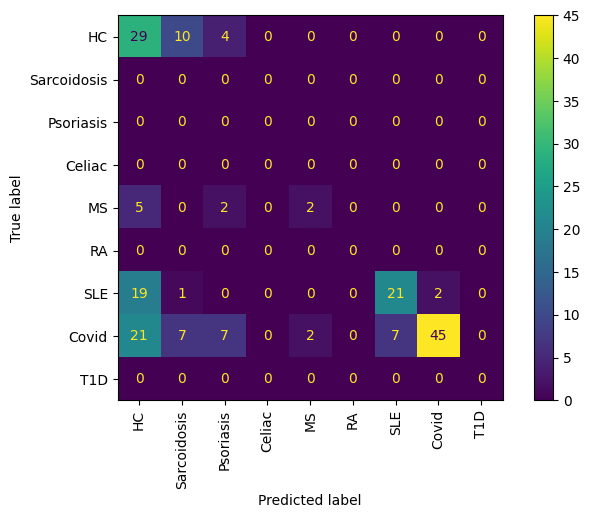

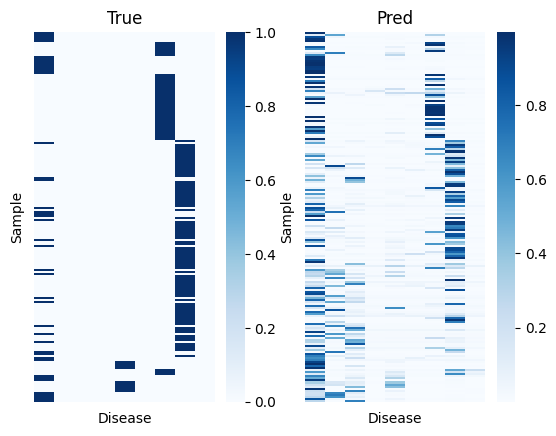

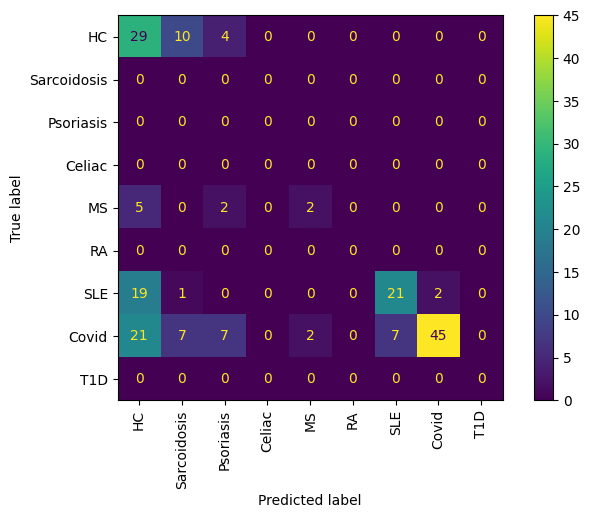

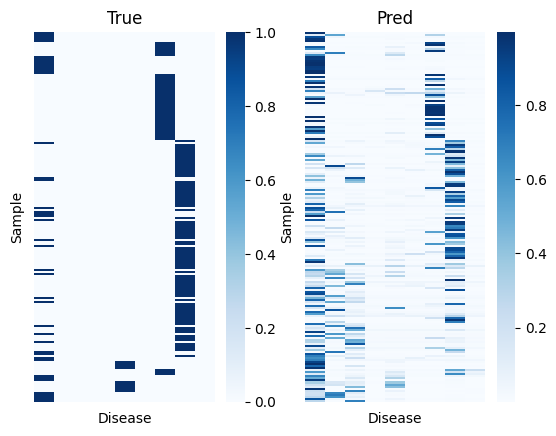

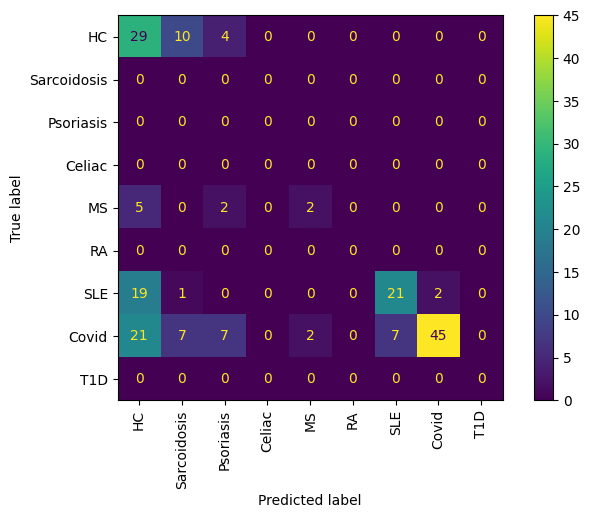

CV score: 0.1809656607373969


In [132]:
for fold in range(FOLD):
    y_test_pred = model.predict(X_test)
    
    f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
    sns.heatmap(np.identity(NUM_CLASS)[y_test], cmap='Blues', ax=ax1)
    ax1.set_title('True')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_ylabel('Sample')
    ax1.set_xlabel('Disease')

    sns.heatmap(y_test_pred, cmap='Blues', ax=ax2)
    ax2.set_title('Pred')
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax2.set_ylabel('Sample')
    ax2.set_xlabel('Disease')
    
    cmat = confusion_matrix(y_test, np.argmax(y_test_pred, axis=1), labels=range(NUM_CLASS))
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        cmat,
        display_labels=df_train['disease'].factorize()[1],
    )

    cmp.plot(ax=ax, xticks_rotation='vertical')
    # ax.set_xticklabels(ax.get_xticks(), rotation = 90)
    plt.show();
    
    if fold == 0:
        conf_mat = cmat
    else:
        conf_mat += cmat

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

In [133]:
for fold in range(FOLD):
    _y_test_pred = model.predict(X_test)
    if fold == 0:
        y_test_pred = _y_test_pred
    else:
        y_test_pred += _y_test_pred
y_test_pred /= FOLD


In [134]:
test_ap = []
for i in range(NUM_CLASS):
    test_ap.append(average_precision_score(np.identity(NUM_CLASS)[y_test][:, i], y_test_pred[:, i]))
    
df_ap = pd.DataFrame([test_ap], columns=df_train['disease'].factorize()[1]).T

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall i

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall i

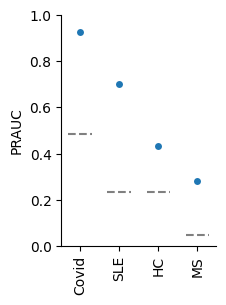

In [135]:
test_ap = []
for i in range(NUM_CLASS):
    test_ap.append(average_precision_score(np.identity(NUM_CLASS)[y_test][:, i], y_test_pred[:, i]))
    
df_ap = pd.DataFrame([test_ap], columns=df_train['disease'].factorize()[1]).T
df_ap = df_ap.iloc[list(set(y_test))]
df_ap_melt = df_ap.reset_index().melt(id_vars='index').dropna()
id_order = df_ap_melt.groupby(by='index').mean().sort_values(by='value', ascending=False).index

df_ap_exp = pd.DataFrame(pd.Series(y_test).value_counts() / len(y_test), columns=['exp'])
df_ap_exp.index = [df_train['disease'].factorize()[1][x] for x in df_ap_exp.index]
df_ap_exp = df_ap_exp.loc[id_order]
df_ap_exp['pos'] = range(df_ap_exp.shape[0])

plt.figure(figsize=(2,3))
sns.swarmplot(data=df_ap_melt, x='index', y='value', order=id_order)
for pos,row in df_ap_exp.iterrows():
    plt.hlines(row['exp'], row['pos']-0.3, row['pos']+0.3, colors='grey', linestyles='--')
plt.xticks(rotation=90)
plt.ylabel('PRAUC')
plt.xlabel(None)
plt.ylim(0,1)
sns.despine()

plt.savefig('../scanpy/{}'.format(version) + '/PRAUC_withNMF.pdf', bbox_inches='tight')

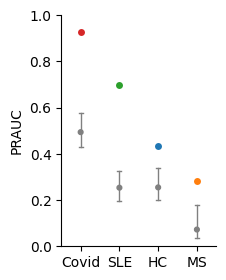

In [136]:
plt.figure(figsize=(2,3))
sns.swarmplot(data=df_ap_melt, x='index', y='value', hue='index', order=id_order, legend=False)
# sns.violinplot(df_ap_shuf.T)
sns.pointplot(df_ap_shuf.T,                   
              estimator= np.mean,
              errorbar=('pi', 95),
                  capsize=.1,
              errwidth=1,
              n_boot=1,
              scale=.5,
                  join=False,
                  color='grey',)

plt.ylabel('PRAUC')
plt.xlabel(None)
plt.ylim(0,1)
sns.despine()

plt.savefig('../scanpy/{}'.format(version) + f'/PRAUC_withNMF_n_perm{num_perm}_pi95.pdf', bbox_inches='tight')

In [137]:
df_ap_melt

index variable     value
0     HC        0  0.432259
1     MS        0  0.283551
2    SLE        0  0.699746
3  Covid        0  0.927500

In [138]:
df_ap

0
HC     0.432259
MS     0.283551
SLE    0.699746
Covid  0.927500

In [139]:
accuracy_score(y_test, np.argmax(y_test_pred, axis=1))

0.5271739130434783

In [140]:
df_test.disease.value_counts() / df_test.shape[0]

Covid    0.483696
HC       0.233696
SLE      0.233696
MS       0.048913
Name: disease, dtype: float64

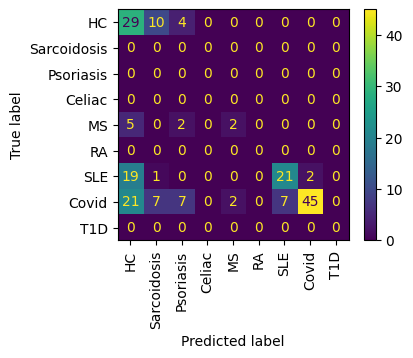

In [141]:
cmat = confusion_matrix(y_test, np.argmax(y_test_pred, axis=1), labels=range(NUM_CLASS))
fig, ax = plt.subplots(figsize=(4,3))
cmp = ConfusionMatrixDisplay(
    cmat,
    display_labels=df_train['disease'].factorize()[1],
)

cmp.plot(ax=ax, xticks_rotation='vertical')
# ax.set_xticklabels(ax.get_xticks(), rotation = 90)

plt.savefig('../scanpy/{}'.format(version) + '/confusionmatrix_withNMF.pdf', bbox_inches='tight')
plt.show();

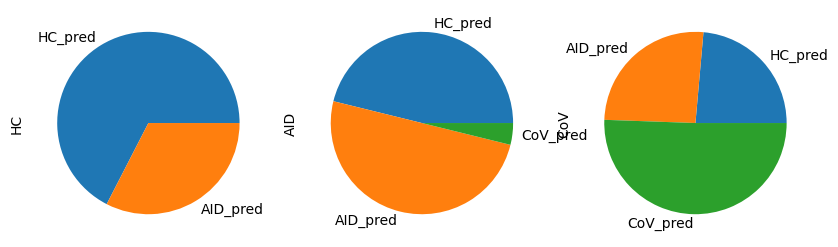

In [142]:
df_conf = pd.DataFrame(conf_mat, columns=df_train['disease'].factorize()[1], index=df_train['disease'].factorize()[1])
# df_conf.head()

df_conf_sum = pd.DataFrame([[df_conf.loc[df_conf.index.isin(list_hc), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_hc), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_hc), list_cov].sum().sum()],
[df_conf.loc[df_conf.index.isin(list_aid), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_aid), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_aid), list_cov].sum().sum()],
[df_conf.loc[df_conf.index.isin(list_cov), list_hc].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_cov), list_aid].sum().sum(),
 df_conf.loc[df_conf.index.isin(list_cov), list_cov].sum().sum()]], index=['HC', 'AID', 'CoV'], columns=['HC_pred', 'AID_pred', 'CoV_pred'])

df_conf_sum.T.plot.pie(subplots=True, figsize=(10,4), legend=False)

plt.savefig('../scanpy/{}'.format(version) + '/pie_withNMF.pdf', bbox_inches='tight')

In [143]:
l = []
for i,m in enumerate(models):
    d_fi = pd.DataFrame(m.feature_importance(), 
                        index=[['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']],
                        columns = [i])
    l.append(d_fi)
df_fi = (pd.concat(l, axis=1))
df_fi.index = [x[0] for x in  df_fi.index]

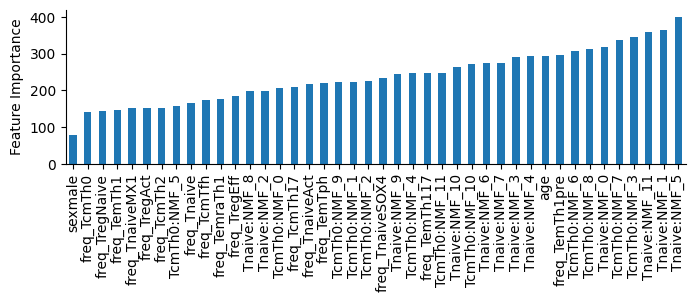

In [144]:
plt.figure(figsize=(8,2))
df_fi.mean(axis=1).sort_values().plot.bar()
plt.ylabel('Feature Importance')
sns.despine()
plt.savefig('../scanpy/{}'.format(version) + '/featureimportance_lgb_all.pdf', bbox_inches='tight')

## prediction only NMF

In [145]:
# X = df[['freq_{}'.format(c) for c in list_celltype_select] + ['age', 'sexmale']]
# X = np.array(X)
# X = df.loc[(df['project'] != 'ours') & (df[list_nmf_col_use].isna().sum(axis=1) == 0), 
#            ['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
# X = np.array(X)
# y = np.array(df.loc[(df['project'] != 'ours') & (df[list_nmf_col_use].isna().sum(axis=1) == 0), 'y'])

# rows_sel = (df[list_nmf_col_use].isna().sum(axis=1) == 0)

# X = df.loc[rows_sel, 
#            ['freq_{}'.format(c) for c in list_celltype_select] + list_nmf_col_use + ['age', 'sexmale']]
X = df_train[list_nmf_col_use + ['age', 'sexmale']]
# y = np.array(df.loc[rows_sel, 'y'])
y = np.array(df_train['y'])

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X)

X = imp.transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [146]:
oversample = SMOTE(sampling_strategy='all')
# oversample = SMOTE(sampling_strategy={i:162 if i != 0 else 220 for i in range(y.max()+1)})
X, y = oversample.fit_resample(X, y)

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.61561
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.3207
[3]	valid_0's multi_logloss: 1.11682
[4]	valid_0's multi_logloss: 0.961206
[5]	valid_0's multi_logloss: 0.840391
[6]	valid_0's multi_logloss: 0.740356
[7]	valid_0's multi_logloss: 0.659901
[8]	valid_0's multi_logloss: 0.594654
[9]	valid_0's multi_logloss: 0.538097
[10]	valid_0's multi_logloss: 0.492083
[11]	valid_0's multi_logloss: 0.450993
[12]	valid_0's multi_logloss: 0.418596
[13]	valid_0's multi_logloss: 0.387319
[14]	valid_0's multi_logloss: 0.36125
[15]	valid_0's multi_logloss: 0.337166
[16]	valid_0's multi_logloss: 0.3161
[17]	valid_0's multi_logloss: 0.29822
[18]	valid_0's multi_logloss: 0.283935
[19]	valid_0's multi_logloss: 0.269849
[20]	valid_0's multi_logloss: 0.256523
[21]	valid_0's multi_logloss: 0.24539
[22]	valid_0's multi_logloss: 0.23659
[23]	valid_0's multi_logloss: 0.227909
[24]	valid_0's multi_logloss: 0.219802
[25]	valid_0's multi_l

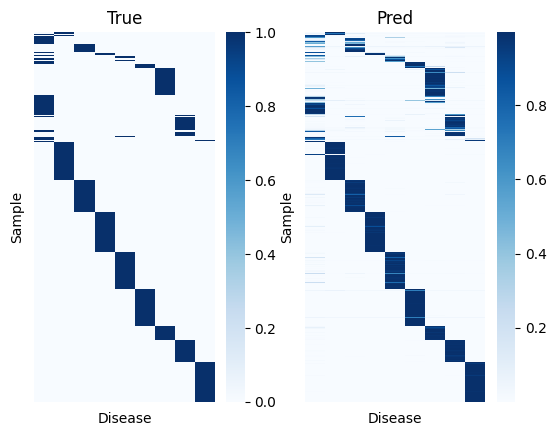

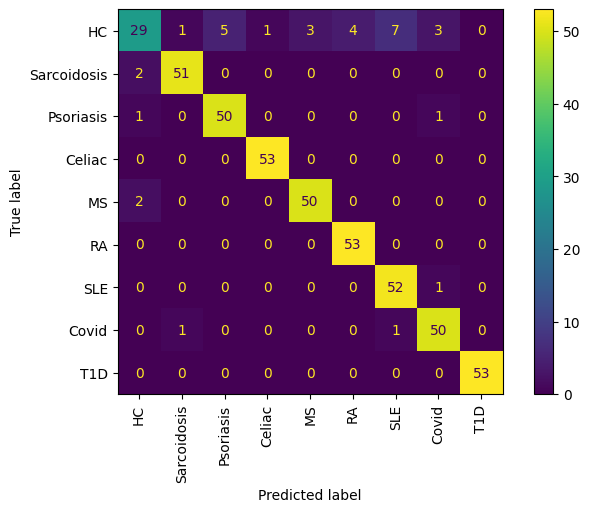

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.61931
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.32113
[3]	valid_0's multi_logloss: 1.11595
[4]	valid_0's multi_logloss: 0.95746
[5]	valid_0's multi_logloss: 0.836201
[6]	valid_0's multi_logloss: 0.739792
[7]	valid_0's multi_logloss: 0.656455
[8]	valid_0's multi_logloss: 0.585696
[9]	valid_0's multi_logloss: 0.525464
[10]	valid_0's multi_logloss: 0.47735
[11]	valid_0's multi_logloss: 0.437036
[12]	valid_0's multi_logloss: 0.401308
[13]	valid_0's multi_logloss: 0.37087
[14]	valid_0's multi_logloss: 0.342076
[15]	valid_0's multi_logloss: 0.319968
[16]	valid_0's multi_logloss: 0.29934
[17]	valid_0's multi_logloss: 0.283267
[18]	valid_0's multi_logloss: 0.270127
[19]	valid_0's multi_logloss: 0.256738
[20]	valid_0's multi_logloss: 0.247759
[21]	valid_0's multi_logloss: 0.2382
[22]	valid_0's multi_logloss: 0.227909
[23]	valid_0's multi_logloss: 0.219655
[24]	valid_0's multi_logloss: 0.211502
[25]	valid_0's multi_

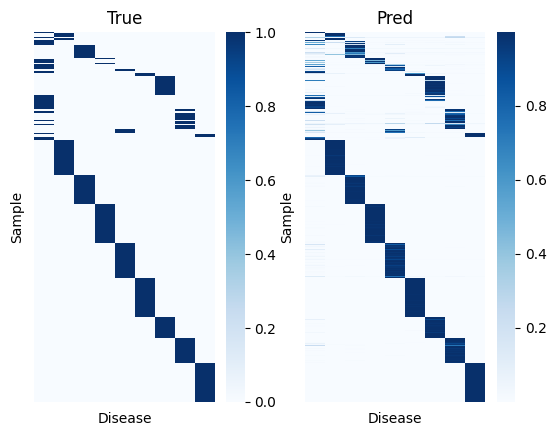

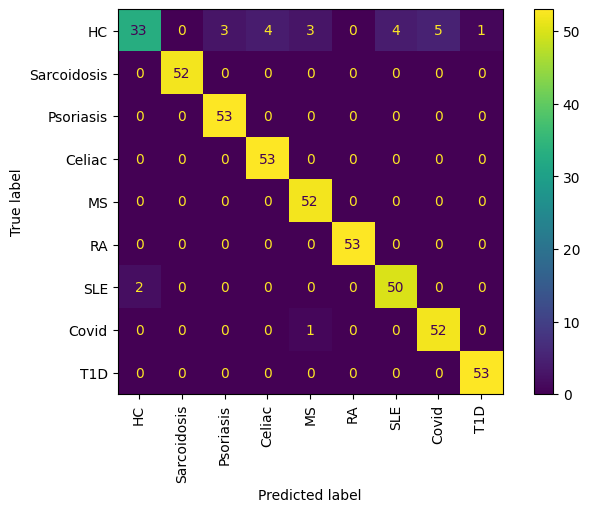

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.62107
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.32369
[3]	valid_0's multi_logloss: 1.12314
[4]	valid_0's multi_logloss: 0.969224
[5]	valid_0's multi_logloss: 0.846592
[6]	valid_0's multi_logloss: 0.746197
[7]	valid_0's multi_logloss: 0.665004
[8]	valid_0's multi_logloss: 0.599678
[9]	valid_0's multi_logloss: 0.54201
[10]	valid_0's multi_logloss: 0.492031
[11]	valid_0's multi_logloss: 0.448414
[12]	valid_0's multi_logloss: 0.410597
[13]	valid_0's multi_logloss: 0.379012
[14]	valid_0's multi_logloss: 0.351156
[15]	valid_0's multi_logloss: 0.32705
[16]	valid_0's multi_logloss: 0.306065
[17]	valid_0's multi_logloss: 0.288228
[18]	valid_0's multi_logloss: 0.273392
[19]	valid_0's multi_logloss: 0.258568
[20]	valid_0's multi_logloss: 0.245816
[21]	valid_0's multi_logloss: 0.237342
[22]	valid_0's multi_logloss: 0.229353
[23]	valid_0's multi_logloss: 0.222985
[24]	valid_0's multi_logloss: 0.213292
[25]	valid_0's mu

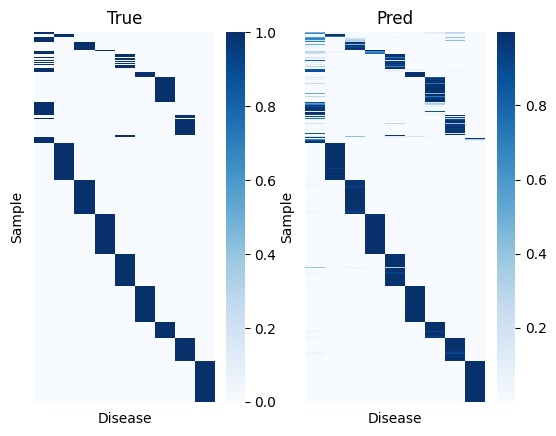

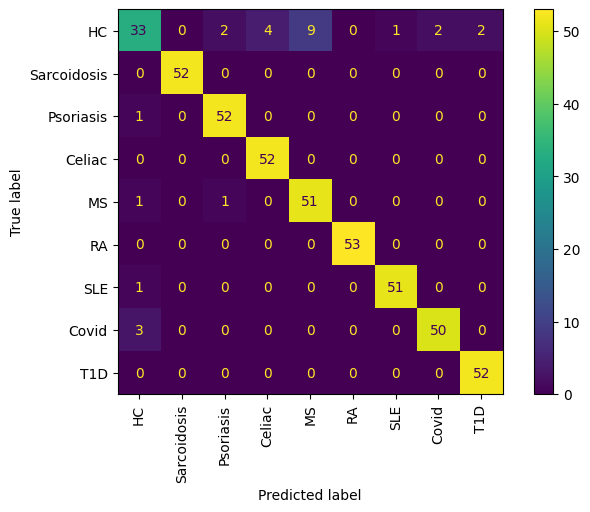

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.60815
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.32012
[3]	valid_0's multi_logloss: 1.11061
[4]	valid_0's multi_logloss: 0.958038
[5]	valid_0's multi_logloss: 0.837369
[6]	valid_0's multi_logloss: 0.739885
[7]	valid_0's multi_logloss: 0.661289
[8]	valid_0's multi_logloss: 0.592301
[9]	valid_0's multi_logloss: 0.535866
[10]	valid_0's multi_logloss: 0.487066
[11]	valid_0's multi_logloss: 0.442885
[12]	valid_0's multi_logloss: 0.408459
[13]	valid_0's multi_logloss: 0.379043
[14]	valid_0's multi_logloss: 0.352903
[15]	valid_0's multi_logloss: 0.331206
[16]	valid_0's multi_logloss: 0.313098
[17]	valid_0's multi_logloss: 0.297154
[18]	valid_0's multi_logloss: 0.282857
[19]	valid_0's multi_logloss: 0.271719
[20]	valid_0's multi_logloss: 0.261252
[21]	valid_0's multi_logloss: 0.252913
[22]	valid_0's multi_logloss: 0.244553
[23]	valid_0's multi_logloss: 0.235808
[24]	valid_0's multi_logloss: 0.229386
[25]	valid_0's 

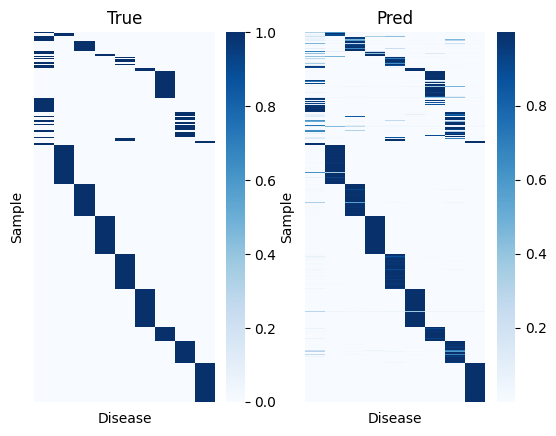

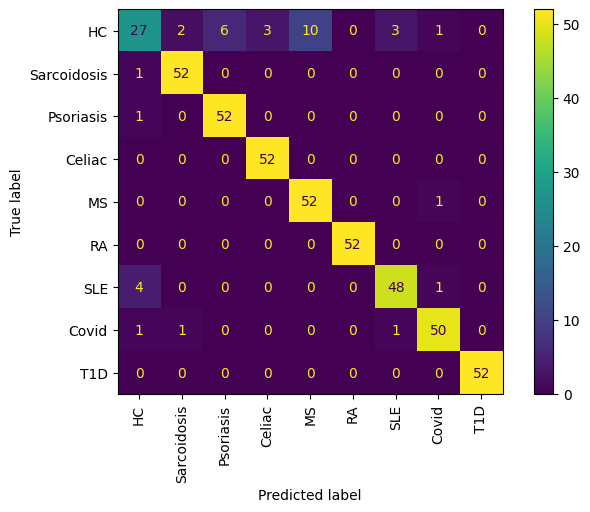

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.62739
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.32888
[3]	valid_0's multi_logloss: 1.12283
[4]	valid_0's multi_logloss: 0.968299
[5]	valid_0's multi_logloss: 0.843077
[6]	valid_0's multi_logloss: 0.74613
[7]	valid_0's multi_logloss: 0.665603
[8]	valid_0's multi_logloss: 0.593978
[9]	valid_0's multi_logloss: 0.535433
[10]	valid_0's multi_logloss: 0.48863
[11]	valid_0's multi_logloss: 0.446666
[12]	valid_0's multi_logloss: 0.410132
[13]	valid_0's multi_logloss: 0.377647
[14]	valid_0's multi_logloss: 0.349272
[15]	valid_0's multi_logloss: 0.324065
[16]	valid_0's multi_logloss: 0.304929
[17]	valid_0's multi_logloss: 0.285708
[18]	valid_0's multi_logloss: 0.268619
[19]	valid_0's multi_logloss: 0.25576
[20]	valid_0's multi_logloss: 0.245868
[21]	valid_0's multi_logloss: 0.236486
[22]	valid_0's multi_logloss: 0.228185
[23]	valid_0's multi_logloss: 0.221362
[24]	valid_0's multi_logloss: 0.214479
[25]	valid_0's mul

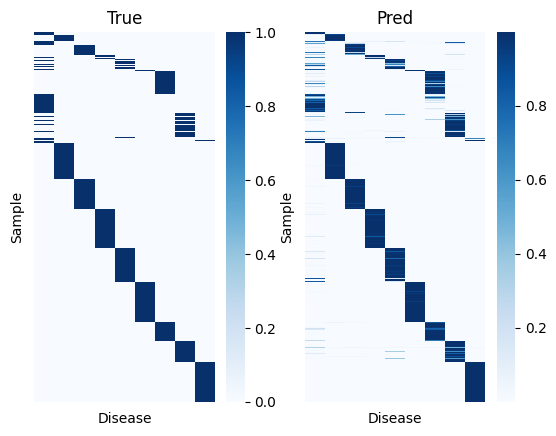

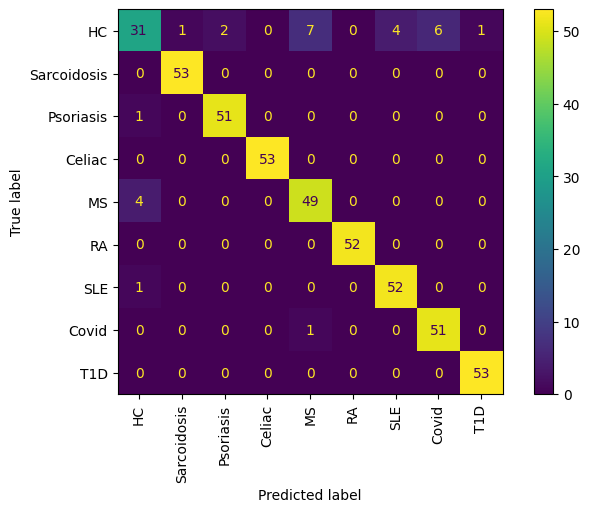

CV score: 0.17851515465765724


In [147]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import numpy as np

valid_scores = []
valid_auc = []
valid_ap = []
models = []
kf = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(X, y)):
    X_train, X_valid = X[train_indices], X[valid_indices]
    y_train, y_valid = y[train_indices], y[valid_indices]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=NUM_ROUND,
        verbose_eval=VERBOSE_EVAL
    )

    y_valid_pred = model.predict(X_valid)
#     score = log_loss(y_valid, y_valid_pred)
    score = log_loss(np.identity(NUM_CLASS)[y_valid], y_valid_pred)
    print(f'fold {fold} log loss: {score}')
    valid_scores.append(score)
    
    ap = []
    for i in range(NUM_CLASS):
        ap.append(average_precision_score(np.identity(NUM_CLASS)[y_valid][:, i], y_valid_pred[:, i]))
    valid_ap.append(ap)
    
    models.append(model)
    
    f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
    sns.heatmap(np.identity(NUM_CLASS)[y_valid], cmap='Blues', ax=ax1)
    ax1.set_title('True')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_ylabel('Sample')
    ax1.set_xlabel('Disease')

    sns.heatmap(y_valid_pred, cmap='Blues', ax=ax2)
    ax2.set_title('Pred')
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax2.set_ylabel('Sample')
    ax2.set_xlabel('Disease')
    
    cmat = confusion_matrix(y_valid, np.argmax(y_valid_pred, axis=1), labels=range(NUM_CLASS))
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        cmat,
        display_labels=df_train['disease'].factorize()[1],
    )

    cmp.plot(ax=ax, xticks_rotation='vertical')
    # ax.set_xticklabels(ax.get_xticks(), rotation = 90)
    plt.show();
    
    if fold == 0:
        conf_mat = cmat
    else:
        conf_mat += cmat

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

In [148]:
X_test = df_test[list_nmf_col_use + ['age', 'sexmale']]
X_test = np.array(X_test)
X_test = imp.transform(X_test)
X_test = scaler.fit_transform(X_test)
y_test = np.array(df_test['y'])

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


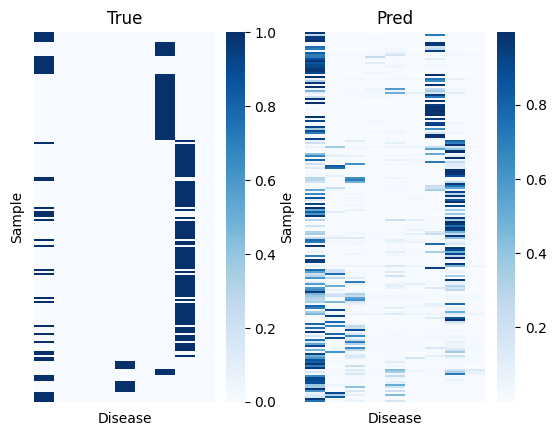

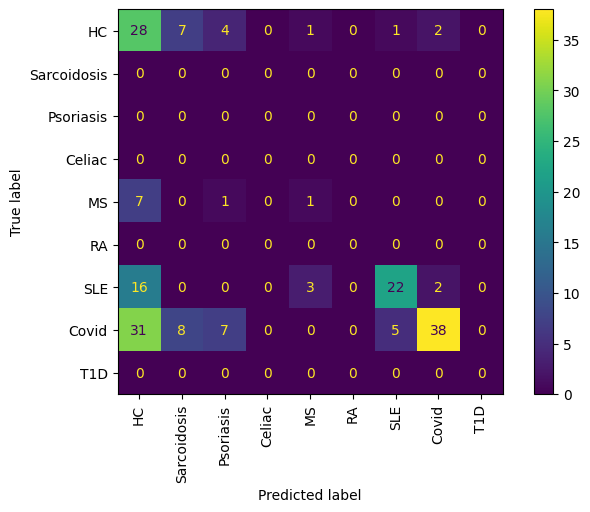

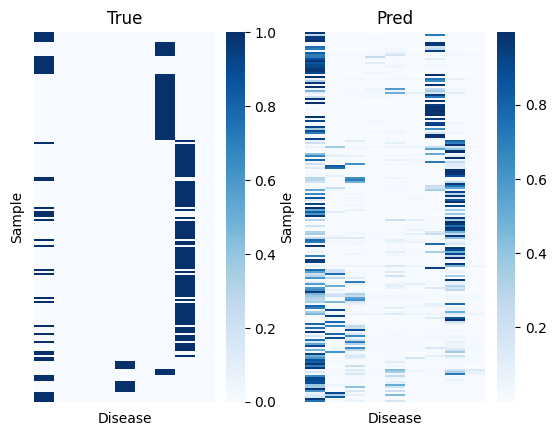

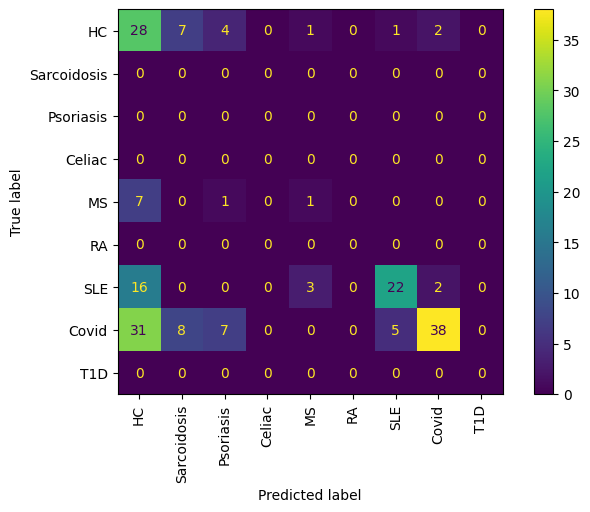

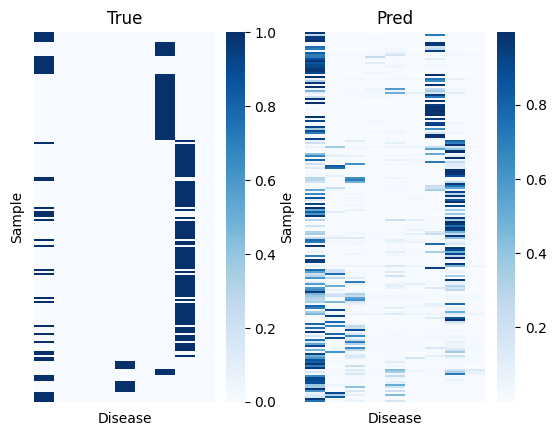

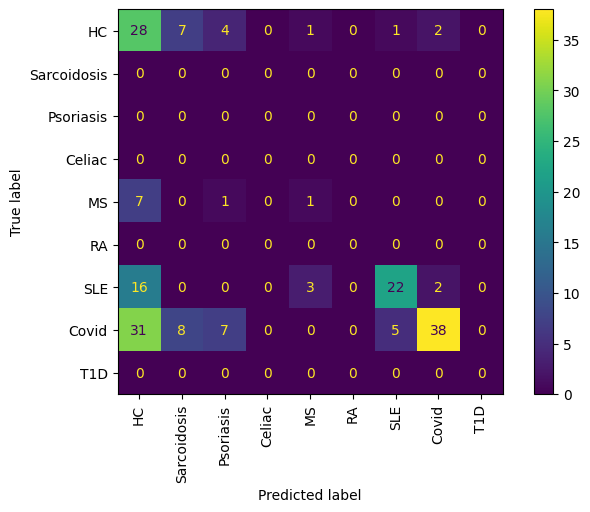

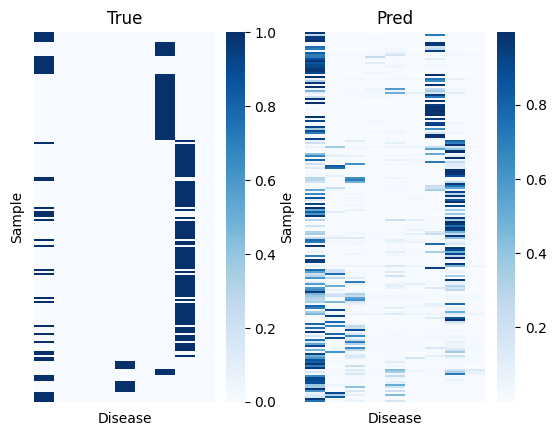

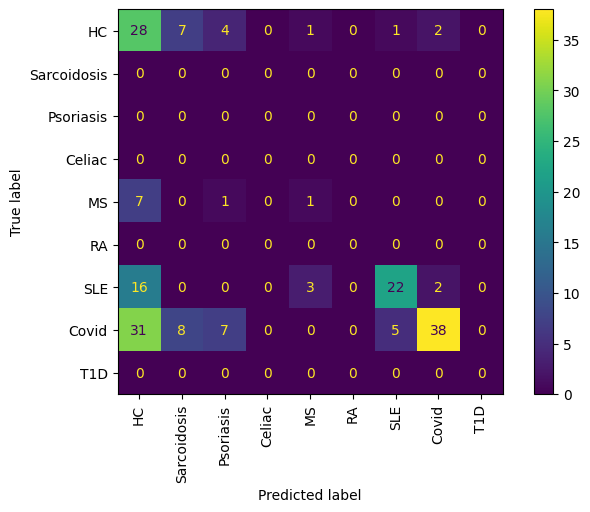

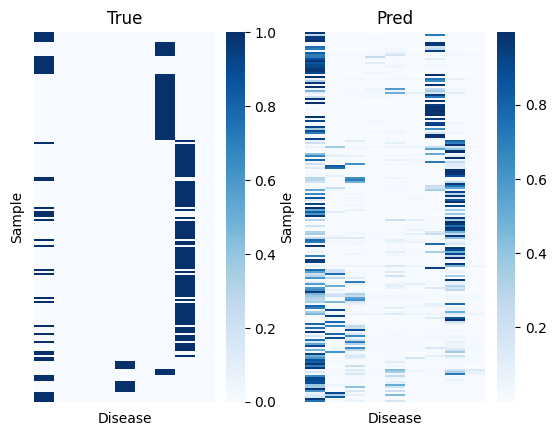

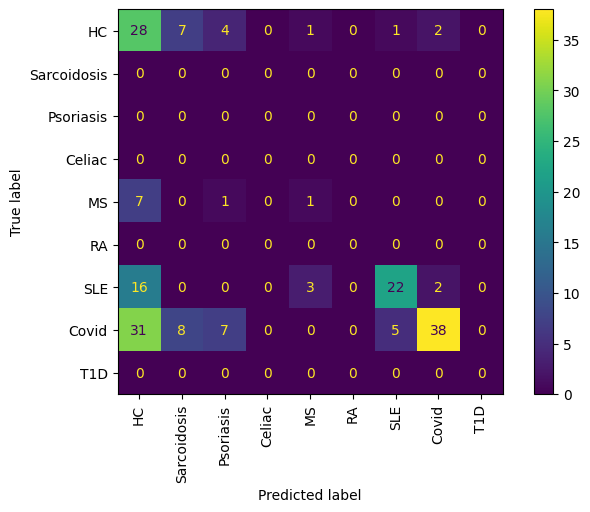

CV score: 0.17851515465765724


In [149]:
for fold in range(FOLD):
    y_test_pred = model.predict(X_test)
    
    f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
    sns.heatmap(np.identity(NUM_CLASS)[y_test], cmap='Blues', ax=ax1)
    ax1.set_title('True')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_ylabel('Sample')
    ax1.set_xlabel('Disease')

    sns.heatmap(y_test_pred, cmap='Blues', ax=ax2)
    ax2.set_title('Pred')
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax2.set_ylabel('Sample')
    ax2.set_xlabel('Disease')
    
    cmat = confusion_matrix(y_test, np.argmax(y_test_pred, axis=1), labels=range(NUM_CLASS))
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        cmat,
        display_labels=df_train['disease'].factorize()[1],
    )

    cmp.plot(ax=ax, xticks_rotation='vertical')
    # ax.set_xticklabels(ax.get_xticks(), rotation = 90)
    plt.show();
    
    if fold == 0:
        conf_mat = cmat
    else:
        conf_mat += cmat

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

In [150]:
for fold in range(FOLD):
    _y_test_pred = model.predict(X_test)
    if fold == 0:
        y_test_pred = _y_test_pred
    else:
        y_test_pred += _y_test_pred
y_test_pred /= FOLD

In [151]:
test_ap = []
for i in range(NUM_CLASS):
    test_ap.append(average_precision_score(np.identity(NUM_CLASS)[y_test][:, i], y_test_pred[:, i]))
    
df_ap = pd.DataFrame([test_ap], columns=df_train['disease'].factorize()[1]).T

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall i

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall i

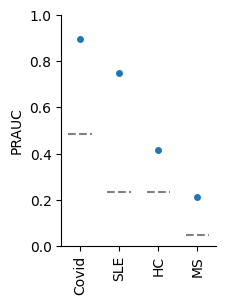

In [152]:
test_ap = []
for i in range(NUM_CLASS):
    test_ap.append(average_precision_score(np.identity(NUM_CLASS)[y_test][:, i], y_test_pred[:, i]))
    
df_ap = pd.DataFrame([test_ap], columns=df_train['disease'].factorize()[1]).T
df_ap = df_ap.iloc[list(set(y_test))]
df_ap_melt = df_ap.reset_index().melt(id_vars='index').dropna()
id_order = df_ap_melt.groupby(by='index').mean().sort_values(by='value', ascending=False).index

df_ap_exp = pd.DataFrame(pd.Series(y_test).value_counts() / len(y_test), columns=['exp'])
df_ap_exp.index = [df_train['disease'].factorize()[1][x] for x in df_ap_exp.index]
df_ap_exp = df_ap_exp.loc[id_order]
df_ap_exp['pos'] = range(df_ap_exp.shape[0])

plt.figure(figsize=(2,3))
sns.swarmplot(data=df_ap_melt, x='index', y='value', order=id_order)
for pos,row in df_ap_exp.iterrows():
    plt.hlines(row['exp'], row['pos']-0.3, row['pos']+0.3, colors='grey', linestyles='--')
plt.xticks(rotation=90)
plt.ylabel('PRAUC')
plt.xlabel(None)
plt.ylim(0,1)
sns.despine()

plt.savefig('../scanpy/{}'.format(version) + '/PRAUC_onlyNMF.pdf', bbox_inches='tight')

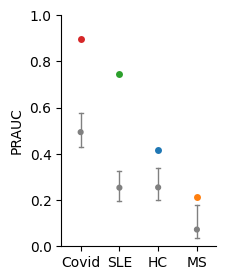

In [153]:
plt.figure(figsize=(2,3))
sns.swarmplot(data=df_ap_melt, x='index', y='value', hue='index', order=id_order, legend=False)
# sns.violinplot(df_ap_shuf.T)
sns.pointplot(df_ap_shuf.T,                   
              estimator= np.mean,
              errorbar=('pi', 95),
                  capsize=.1,
              errwidth=1,
              n_boot=1,
              scale=.5,
                  join=False,
                  color='grey',)

plt.ylabel('PRAUC')
plt.xlabel(None)
plt.ylim(0,1)
sns.despine()

plt.savefig('../scanpy/{}'.format(version) + f'/PRAUC_onlyNMF_n_perm{num_perm}_pi95.pdf', bbox_inches='tight')

In [154]:
df_ap

0
HC     0.417570
MS     0.212395
SLE    0.747096
Covid  0.895357

In [155]:
accuracy_score(y_test, np.argmax(y_test_pred, axis=1))

0.483695652173913

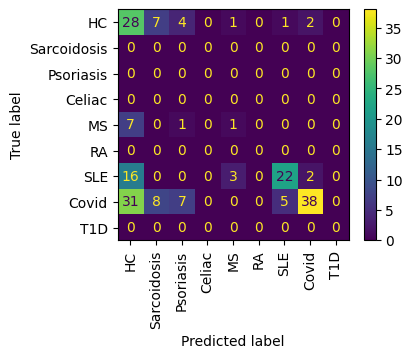

In [156]:
cmat = confusion_matrix(y_test, np.argmax(y_test_pred, axis=1), labels=range(NUM_CLASS))
fig, ax = plt.subplots(figsize=(4,3))
cmp = ConfusionMatrixDisplay(
    cmat,
    display_labels=df_train['disease'].factorize()[1],
)

cmp.plot(ax=ax, xticks_rotation='vertical')
# ax.set_xticklabels(ax.get_xticks(), rotation = 90)

plt.savefig('../scanpy/{}'.format(version) + '/confusionmatrix_onlyNMF.pdf', bbox_inches='tight')
plt.show();